In [2]:
# !python -m pip install --user --upgrade pip
# !python -m pip install --user keras
# !python -m pip install --user tensorflow
# !python -m pip install --user -U numpy
!pip install mibian
#!python -m pip install --user tqdm

  Using cached https://files.pythonhosted.org/packages/e5/74/25719d1f66b84561f209692947980660268cf601dc92766547b626eb03d5/mibian-0.1.3.tar.gz
  Created wheel for mibian: filename=mibian-0.1.3-cp37-none-any.whl size=4040 sha256=5639d0e3e0963acefacff9c922f0c056cfb66292f802b3a3a55ba23073de5002
  Stored in directory: /Users/baronma/Library/Caches/pip/wheels/34/c7/51/22486b811445a01dab50193c9748e94242e55a4ce686a24240
Successfully built mibian


In [14]:
import pandas as pd
from mibian import BS
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tqdm
import sklearn.metrics

In [2]:
df = pd.read_csv('Options_MCdropout_TT.csv')
df = df.dropna()
df['cal_imp_vol']=0
df.dtypes

ticker               object
date                 object
exdate               object
maturity              int64
strike_price        float64
best_offer          float64
impl_volatility     float64
underlying_price    float64
interest_rate       float64
cp_flag_C             int64
cp_flag_P             int64
moneyness           float64
cal_imp_vol           int64
dtype: object

In [35]:
sample_df=df.sample(n=200000)
sample_df.head()

,ticker,date,exdate,maturity,strike_price,best_offer,impl_volatility,underlying_price,interest_rate,cp_flag_C,cp_flag_P,moneyness,cal_imp_vol
824417,AAPL,2014-12-15,2015-01-17,33,95.71,0.60,0.347132,108.225,2.12,0,1,1.130760,0
1569755,GS,2015-12-04,2015-12-24,20,160.00,32.15,0.416019,189.990,2.28,1,0,1.187437,0
175883,AAPL,2013-10-21,2013-12-21,61,735.00,218.15,0.436026,521.362,2.63,0,1,0.709336,0
1922403,GOOGL,2015-11-03,2016-01-15,73,660.00,94.50,0.234246,748.820,2.23,1,0,1.134576,0
712453,AAPL,2014-06-02,2014-07-03,31,560.00,70.05,0.229416,628.650,2.54,1,0,1.122589,0


In [25]:
def BS_ImpVol(df):
    for row in range(0,len(df)):
        underlyingPrice=df.iloc[row]['underlying_price']
        strikePrice=df.iloc[row]['strike_price']
        interestRate=df.iloc[row]['interest_rate']
        daysToExpiration=df.iloc[row]['maturity']
        if df.iloc[row]['cp_flag_C']==1:
            callPrice=df.iloc[row]['best_offer']
            result=BS([underlyingPrice,strikePrice,interestRate,daysToExpiration], callPrice=callPrice)
            df.iloc[row, df.columns.get_loc('cal_imp_vol')]=result.impliedVolatility
        else:
            putPrice=df.iloc[row]['best_offer']
            result=BS([underlyingPrice,strikePrice,interestRate,daysToExpiration], putPrice=putPrice)
            df.iloc[row, df.columns.get_loc('cal_imp_vol')]=result.impliedVolatility
    return df

In [37]:
dfWithVol=BS_ImpVol(sample_df)
dfWithVol.head()

,ticker,date,exdate,maturity,strike_price,best_offer,impl_volatility,underlying_price,interest_rate,cp_flag_C,cp_flag_P,moneyness,cal_imp_vol
824417,AAPL,2014-12-15,2015-01-17,33,95.71,0.60,0.347132,108.225,2.12,0,1,1.130760,35.156250
1569755,GS,2015-12-04,2015-12-24,20,160.00,32.15,0.416019,189.990,2.28,1,0,1.187437,68.115234
175883,AAPL,2013-10-21,2013-12-21,61,735.00,218.15,0.436026,521.362,2.63,0,1,0.709336,64.819336
1922403,GOOGL,2015-11-03,2016-01-15,73,660.00,94.50,0.234246,748.820,2.23,1,0,1.134576,21.606445
712453,AAPL,2014-06-02,2014-07-03,31,560.00,70.05,0.229416,628.650,2.54,1,0,1.122589,18.920898


In [10]:
def model_hyper_optimization(dropout_rate=0.05, init_mode='uniform'):
    model = Sequential()
    model.add(Dense(100, input_dim=7, kernel_initializer=init_mode, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(200, kernel_initializer=init_mode, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(300, kernel_initializer=init_mode, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(200, kernel_initializer=init_mode, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(100, kernel_initializer=init_mode, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_initializer=init_mode, activation='linear'))
    # Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

# create model
model = KerasRegressor(build_fn=model_hyper_optimization, verbose=2)
# define the grid search parameters
batch_size = [256, 512, 1024]
epochs = [100,150,200]
init_mode = ['uniform', 'glorot_uniform']
dropout_rate = [0.05, 0.1, 0.2]
param_grid = dict(batch_size=batch_size, epochs=epochs, init_mode=init_mode, dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

In [15]:
ss_df=sample_df.sample(n=10000)
ss_X=ss_df[['underlying_price', 'strike_price', 'cp_flag_C', 'cp_flag_P', 'interest_rate', 'maturity', 'best_offer']]
ss_y=ss_df['cal_imp_vol'].values
sc_X = MinMaxScaler(feature_range=(0, 1))
sc_X.fit(ss_X)
XX_scale = sc_X.transform(ss_X)

grid_result = grid.fit(XX_scale, ss_y)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 1s - loss: 0.0558 - mean_absolute_error: 0.1815
Epoch 2/100
 - 0s - loss: 0.0192 - mean_absolute_error: 0.0929
Epoch 3/100
 - 0s - loss: 0.0169 - mean_absolute_error: 0.0861
Epoch 4/100
 - 0s - loss: 0.0150 - mean_absolute_error: 0.0798
Epoch 5/100
 - 0s - loss: 0.0135 - mean_absolute_error: 0.0774
Epoch 6/100
 - 1s - loss: 0.0124 - mean_absolute_error: 0.0761
Epoch 7/100
 - 0s - loss: 0.0109 - mean_absolute_error: 0.0696
Epoch 8/100
 - 0s - loss: 0.0103 - mean_absolute_error: 0.0683
Epoch 9/100
 - 0s - loss: 0.0098 - mean_absolute_error: 0.0670
Epoch 10/100
 - 0s - loss: 0.0095 - mean_absolute_error: 0.0671
Epoch 11/100
 - 1s - loss: 0.0084 - mean_absolute_error: 0.0624
Epoch 12/100
 - 0s - loss: 0.0077 - mean_absolute_error: 0.0609
Epoch 13/100
 - 0s - loss: 0.0069 - mean_absolute_error: 0.0583
Epoch 14/100
 - 0s - loss: 0.0063 - mean_absolute_error: 0.0564
Epoch 15/100
 - 0s - loss: 0.0065 - mean_absolute_error: 0.0571
E

Epoch 25/100
 - 1s - loss: 0.0051 - mean_absolute_error: 0.0510
Epoch 26/100
 - 1s - loss: 0.0049 - mean_absolute_error: 0.0497
Epoch 27/100
 - 0s - loss: 0.0076 - mean_absolute_error: 0.0623
Epoch 28/100
 - 0s - loss: 0.0052 - mean_absolute_error: 0.0513
Epoch 29/100
 - 1s - loss: 0.0054 - mean_absolute_error: 0.0519
Epoch 30/100
 - 0s - loss: 0.0049 - mean_absolute_error: 0.0500
Epoch 31/100
 - 1s - loss: 0.0046 - mean_absolute_error: 0.0487
Epoch 32/100
 - 1s - loss: 0.0049 - mean_absolute_error: 0.0498
Epoch 33/100
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0481
Epoch 34/100
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0485
Epoch 35/100
 - 1s - loss: 0.0045 - mean_absolute_error: 0.0479
Epoch 36/100
 - 1s - loss: 0.0045 - mean_absolute_error: 0.0474
Epoch 37/100
 - 1s - loss: 0.0046 - mean_absolute_error: 0.0481
Epoch 38/100
 - 1s - loss: 0.0042 - mean_absolute_error: 0.0469
Epoch 39/100
 - 0s - loss: 0.0043 - mean_absolute_error: 0.0464
Epoch 40/100
 - 0s - loss: 0.0045 - mean

 - 0s - loss: 0.0038 - mean_absolute_error: 0.0427
Epoch 54/100
 - 1s - loss: 0.0039 - mean_absolute_error: 0.0444
Epoch 55/100
 - 1s - loss: 0.0036 - mean_absolute_error: 0.0426
Epoch 56/100
 - 1s - loss: 0.0038 - mean_absolute_error: 0.0435
Epoch 57/100
 - 1s - loss: 0.0036 - mean_absolute_error: 0.0428
Epoch 58/100
 - 1s - loss: 0.0035 - mean_absolute_error: 0.0422
Epoch 59/100
 - 1s - loss: 0.0048 - mean_absolute_error: 0.0488
Epoch 60/100
 - 1s - loss: 0.0041 - mean_absolute_error: 0.0455
Epoch 61/100
 - 1s - loss: 0.0039 - mean_absolute_error: 0.0443
Epoch 62/100
 - 1s - loss: 0.0044 - mean_absolute_error: 0.0467
Epoch 63/100
 - 1s - loss: 0.0037 - mean_absolute_error: 0.0438
Epoch 64/100
 - 1s - loss: 0.0039 - mean_absolute_error: 0.0433
Epoch 65/100
 - 1s - loss: 0.0037 - mean_absolute_error: 0.0430
Epoch 66/100
 - 1s - loss: 0.0034 - mean_absolute_error: 0.0413
Epoch 67/100
 - 1s - loss: 0.0034 - mean_absolute_error: 0.0406
Epoch 68/100
 - 1s - loss: 0.0037 - mean_absolute_err

Epoch 82/100
 - 1s - loss: 0.0029 - mean_absolute_error: 0.0379
Epoch 83/100
 - 0s - loss: 0.0029 - mean_absolute_error: 0.0382
Epoch 84/100
 - 1s - loss: 0.0028 - mean_absolute_error: 0.0375
Epoch 85/100
 - 0s - loss: 0.0082 - mean_absolute_error: 0.0574
Epoch 86/100
 - 0s - loss: 0.0052 - mean_absolute_error: 0.0504
Epoch 87/100
 - 1s - loss: 0.0040 - mean_absolute_error: 0.0448
Epoch 88/100
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0469
Epoch 89/100
 - 0s - loss: 0.0036 - mean_absolute_error: 0.0425
Epoch 90/100
 - 0s - loss: 0.0036 - mean_absolute_error: 0.0425
Epoch 91/100
 - 1s - loss: 0.0032 - mean_absolute_error: 0.0400
Epoch 92/100
 - 1s - loss: 0.0036 - mean_absolute_error: 0.0418
Epoch 93/100
 - 0s - loss: 0.0036 - mean_absolute_error: 0.0426
Epoch 94/100
 - 0s - loss: 0.0032 - mean_absolute_error: 0.0405
Epoch 95/100
 - 0s - loss: 0.0031 - mean_absolute_error: 0.0395
Epoch 96/100
 - 1s - loss: 0.0034 - mean_absolute_error: 0.0414
Epoch 97/100
 - 0s - loss: 0.0045 - mean

Epoch 11/100
 - 0s - loss: 0.0075 - mean_absolute_error: 0.0603
Epoch 12/100
 - 0s - loss: 0.0076 - mean_absolute_error: 0.0603
Epoch 13/100
 - 0s - loss: 0.0077 - mean_absolute_error: 0.0614
Epoch 14/100
 - 0s - loss: 0.0073 - mean_absolute_error: 0.0601
Epoch 15/100
 - 0s - loss: 0.0072 - mean_absolute_error: 0.0594
Epoch 16/100
 - 0s - loss: 0.0076 - mean_absolute_error: 0.0612
Epoch 17/100
 - 0s - loss: 0.0067 - mean_absolute_error: 0.0580
Epoch 18/100
 - 0s - loss: 0.0064 - mean_absolute_error: 0.0557
Epoch 19/100
 - 0s - loss: 0.0061 - mean_absolute_error: 0.0552
Epoch 20/100
 - 0s - loss: 0.0061 - mean_absolute_error: 0.0548
Epoch 21/100
 - 0s - loss: 0.0058 - mean_absolute_error: 0.0534
Epoch 22/100
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0537
Epoch 23/100
 - 0s - loss: 0.0057 - mean_absolute_error: 0.0536
Epoch 24/100
 - 0s - loss: 0.0053 - mean_absolute_error: 0.0516
Epoch 25/100
 - 0s - loss: 0.0056 - mean_absolute_error: 0.0521
Epoch 26/100
 - 0s - loss: 0.0052 - mean

 - 1s - loss: 0.0044 - mean_absolute_error: 0.0463
Epoch 40/150
 - 1s - loss: 0.0046 - mean_absolute_error: 0.0483
Epoch 41/150
 - 0s - loss: 0.0044 - mean_absolute_error: 0.0470
Epoch 42/150
 - 0s - loss: 0.0040 - mean_absolute_error: 0.0452
Epoch 43/150
 - 1s - loss: 0.0039 - mean_absolute_error: 0.0446
Epoch 44/150
 - 1s - loss: 0.0039 - mean_absolute_error: 0.0447
Epoch 45/150
 - 1s - loss: 0.0040 - mean_absolute_error: 0.0451
Epoch 46/150
 - 0s - loss: 0.0036 - mean_absolute_error: 0.0421
Epoch 47/150
 - 0s - loss: 0.0037 - mean_absolute_error: 0.0433
Epoch 48/150
 - 1s - loss: 0.0039 - mean_absolute_error: 0.0442
Epoch 49/150
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0451
Epoch 50/150
 - 1s - loss: 0.0038 - mean_absolute_error: 0.0439
Epoch 51/150
 - 1s - loss: 0.0038 - mean_absolute_error: 0.0440
Epoch 52/150
 - 1s - loss: 0.0041 - mean_absolute_error: 0.0460
Epoch 53/150
 - 1s - loss: 0.0035 - mean_absolute_error: 0.0416
Epoch 54/150
 - 1s - loss: 0.0033 - mean_absolute_err

Epoch 17/150
 - 1s - loss: 0.0058 - mean_absolute_error: 0.0542
Epoch 18/150
 - 1s - loss: 0.0058 - mean_absolute_error: 0.0540
Epoch 19/150
 - 1s - loss: 0.0056 - mean_absolute_error: 0.0531
Epoch 20/150
 - 1s - loss: 0.0052 - mean_absolute_error: 0.0511
Epoch 21/150
 - 1s - loss: 0.0054 - mean_absolute_error: 0.0522
Epoch 22/150
 - 1s - loss: 0.0050 - mean_absolute_error: 0.0509
Epoch 23/150
 - 1s - loss: 0.0048 - mean_absolute_error: 0.0496
Epoch 24/150
 - 1s - loss: 0.0051 - mean_absolute_error: 0.0505
Epoch 25/150
 - 1s - loss: 0.0055 - mean_absolute_error: 0.0527
Epoch 26/150
 - 1s - loss: 0.0050 - mean_absolute_error: 0.0501
Epoch 27/150
 - 1s - loss: 0.0049 - mean_absolute_error: 0.0501
Epoch 28/150
 - 1s - loss: 0.0046 - mean_absolute_error: 0.0483
Epoch 29/150
 - 1s - loss: 0.0044 - mean_absolute_error: 0.0474
Epoch 30/150
 - 1s - loss: 0.0046 - mean_absolute_error: 0.0480
Epoch 31/150
 - 1s - loss: 0.0043 - mean_absolute_error: 0.0471
Epoch 32/150
 - 1s - loss: 0.0043 - mean

Epoch 145/150
 - 1s - loss: 0.0026 - mean_absolute_error: 0.0355
Epoch 146/150
 - 1s - loss: 0.0027 - mean_absolute_error: 0.0364
Epoch 147/150
 - 1s - loss: 0.0029 - mean_absolute_error: 0.0379
Epoch 148/150
 - 1s - loss: 0.0026 - mean_absolute_error: 0.0358
Epoch 149/150
 - 1s - loss: 0.0026 - mean_absolute_error: 0.0356
Epoch 150/150
 - 1s - loss: 0.0028 - mean_absolute_error: 0.0374
Epoch 1/150
 - 2s - loss: 0.0522 - mean_absolute_error: 0.1745
Epoch 2/150
 - 1s - loss: 0.0186 - mean_absolute_error: 0.0924
Epoch 3/150
 - 1s - loss: 0.0159 - mean_absolute_error: 0.0830
Epoch 4/150
 - 1s - loss: 0.0137 - mean_absolute_error: 0.0777
Epoch 5/150
 - 1s - loss: 0.0119 - mean_absolute_error: 0.0726
Epoch 6/150
 - 1s - loss: 0.0107 - mean_absolute_error: 0.0693
Epoch 7/150
 - 1s - loss: 0.0101 - mean_absolute_error: 0.0673
Epoch 8/150
 - 1s - loss: 0.0096 - mean_absolute_error: 0.0669
Epoch 9/150
 - 1s - loss: 0.0087 - mean_absolute_error: 0.0642
Epoch 10/150
 - 1s - loss: 0.0102 - mean_ab

Epoch 123/150
 - 1s - loss: 0.0030 - mean_absolute_error: 0.0381
Epoch 124/150
 - 1s - loss: 0.0030 - mean_absolute_error: 0.0385
Epoch 125/150
 - 1s - loss: 0.0028 - mean_absolute_error: 0.0370
Epoch 126/150
 - 1s - loss: 0.0032 - mean_absolute_error: 0.0398
Epoch 127/150
 - 1s - loss: 0.0030 - mean_absolute_error: 0.0381
Epoch 128/150
 - 1s - loss: 0.0034 - mean_absolute_error: 0.0407
Epoch 129/150
 - 1s - loss: 0.0031 - mean_absolute_error: 0.0398
Epoch 130/150
 - 1s - loss: 0.0027 - mean_absolute_error: 0.0367
Epoch 131/150
 - 1s - loss: 0.0027 - mean_absolute_error: 0.0361
Epoch 132/150
 - 1s - loss: 0.0027 - mean_absolute_error: 0.0361
Epoch 133/150
 - 1s - loss: 0.0028 - mean_absolute_error: 0.0376
Epoch 134/150
 - 1s - loss: 0.0030 - mean_absolute_error: 0.0385
Epoch 135/150
 - 1s - loss: 0.0028 - mean_absolute_error: 0.0370
Epoch 136/150
 - 1s - loss: 0.0027 - mean_absolute_error: 0.0365
Epoch 137/150
 - 1s - loss: 0.0027 - mean_absolute_error: 0.0364
Epoch 138/150
 - 1s - los

Epoch 101/150
 - 1s - loss: 0.0031 - mean_absolute_error: 0.0390
Epoch 102/150
 - 1s - loss: 0.0031 - mean_absolute_error: 0.0390
Epoch 103/150
 - 1s - loss: 0.0029 - mean_absolute_error: 0.0373
Epoch 104/150
 - 1s - loss: 0.0030 - mean_absolute_error: 0.0381
Epoch 105/150
 - 1s - loss: 0.0028 - mean_absolute_error: 0.0367
Epoch 106/150
 - 1s - loss: 0.0032 - mean_absolute_error: 0.0394
Epoch 107/150
 - 1s - loss: 0.0030 - mean_absolute_error: 0.0380
Epoch 108/150
 - 1s - loss: 0.0037 - mean_absolute_error: 0.0430
Epoch 109/150
 - 1s - loss: 0.0031 - mean_absolute_error: 0.0390
Epoch 110/150
 - 1s - loss: 0.0029 - mean_absolute_error: 0.0372
Epoch 111/150
 - 1s - loss: 0.0029 - mean_absolute_error: 0.0378
Epoch 112/150
 - 1s - loss: 0.0027 - mean_absolute_error: 0.0362
Epoch 113/150
 - 1s - loss: 0.0028 - mean_absolute_error: 0.0367
Epoch 114/150
 - 1s - loss: 0.0027 - mean_absolute_error: 0.0364
Epoch 115/150
 - 1s - loss: 0.0028 - mean_absolute_error: 0.0369
Epoch 116/150
 - 1s - los

Epoch 79/150
 - 1s - loss: 0.0029 - mean_absolute_error: 0.0381
Epoch 80/150
 - 1s - loss: 0.0029 - mean_absolute_error: 0.0381
Epoch 81/150
 - 1s - loss: 0.0030 - mean_absolute_error: 0.0385
Epoch 82/150
 - 1s - loss: 0.0028 - mean_absolute_error: 0.0375
Epoch 83/150
 - 1s - loss: 0.0029 - mean_absolute_error: 0.0375
Epoch 84/150
 - 1s - loss: 0.0029 - mean_absolute_error: 0.0376
Epoch 85/150
 - 1s - loss: 0.0030 - mean_absolute_error: 0.0387
Epoch 86/150
 - 1s - loss: 0.0028 - mean_absolute_error: 0.0373
Epoch 87/150
 - 1s - loss: 0.0027 - mean_absolute_error: 0.0368
Epoch 88/150
 - 1s - loss: 0.0028 - mean_absolute_error: 0.0373
Epoch 89/150
 - 1s - loss: 0.0028 - mean_absolute_error: 0.0372
Epoch 90/150
 - 1s - loss: 0.0030 - mean_absolute_error: 0.0390
Epoch 91/150
 - 1s - loss: 0.0028 - mean_absolute_error: 0.0374
Epoch 92/150
 - 1s - loss: 0.0028 - mean_absolute_error: 0.0369
Epoch 93/150
 - 1s - loss: 0.0027 - mean_absolute_error: 0.0365
Epoch 94/150
 - 1s - loss: 0.0032 - mean

Epoch 57/150
 - 1s - loss: 0.0058 - mean_absolute_error: 0.0527
Epoch 58/150
 - 1s - loss: 0.0043 - mean_absolute_error: 0.0468
Epoch 59/150
 - 1s - loss: 0.0038 - mean_absolute_error: 0.0440
Epoch 60/150
 - 1s - loss: 0.0040 - mean_absolute_error: 0.0446
Epoch 61/150
 - 1s - loss: 0.0041 - mean_absolute_error: 0.0447
Epoch 62/150
 - 1s - loss: 0.0037 - mean_absolute_error: 0.0430
Epoch 63/150
 - 1s - loss: 0.0037 - mean_absolute_error: 0.0422
Epoch 64/150
 - 1s - loss: 0.0034 - mean_absolute_error: 0.0409
Epoch 65/150
 - 1s - loss: 0.0034 - mean_absolute_error: 0.0413
Epoch 66/150
 - 1s - loss: 0.0034 - mean_absolute_error: 0.0409
Epoch 67/150
 - 1s - loss: 0.0038 - mean_absolute_error: 0.0433
Epoch 68/150
 - 1s - loss: 0.0033 - mean_absolute_error: 0.0404
Epoch 69/150
 - 1s - loss: 0.0033 - mean_absolute_error: 0.0406
Epoch 70/150
 - 1s - loss: 0.0033 - mean_absolute_error: 0.0403
Epoch 71/150
 - 1s - loss: 0.0033 - mean_absolute_error: 0.0399
Epoch 72/150
 - 1s - loss: 0.0032 - mean

Epoch 35/100
 - 1s - loss: 0.0065 - mean_absolute_error: 0.0567
Epoch 36/100
 - 1s - loss: 0.0053 - mean_absolute_error: 0.0509
Epoch 37/100
 - 1s - loss: 0.0050 - mean_absolute_error: 0.0501
Epoch 38/100
 - 1s - loss: 0.0050 - mean_absolute_error: 0.0504
Epoch 39/100
 - 1s - loss: 0.0047 - mean_absolute_error: 0.0486
Epoch 40/100
 - 1s - loss: 0.0055 - mean_absolute_error: 0.0526
Epoch 41/100
 - 1s - loss: 0.0048 - mean_absolute_error: 0.0490
Epoch 42/100
 - 1s - loss: 0.0048 - mean_absolute_error: 0.0492
Epoch 43/100
 - 1s - loss: 0.0054 - mean_absolute_error: 0.0520
Epoch 44/100
 - 1s - loss: 0.0047 - mean_absolute_error: 0.0480
Epoch 45/100
 - 1s - loss: 0.0049 - mean_absolute_error: 0.0499
Epoch 46/100
 - 1s - loss: 0.0045 - mean_absolute_error: 0.0475
Epoch 47/100
 - 1s - loss: 0.0054 - mean_absolute_error: 0.0524
Epoch 48/100
 - 1s - loss: 0.0045 - mean_absolute_error: 0.0475
Epoch 49/100
 - 1s - loss: 0.0045 - mean_absolute_error: 0.0479
Epoch 50/100
 - 1s - loss: 0.0045 - mean

 - 1s - loss: 0.0036 - mean_absolute_error: 0.0424
Epoch 64/100
 - 1s - loss: 0.0037 - mean_absolute_error: 0.0427
Epoch 65/100
 - 1s - loss: 0.0039 - mean_absolute_error: 0.0444
Epoch 66/100
 - 1s - loss: 0.0037 - mean_absolute_error: 0.0433
Epoch 67/100
 - 1s - loss: 0.0036 - mean_absolute_error: 0.0425
Epoch 68/100
 - 1s - loss: 0.0045 - mean_absolute_error: 0.0479
Epoch 69/100
 - 1s - loss: 0.0050 - mean_absolute_error: 0.0506
Epoch 70/100
 - 1s - loss: 0.0041 - mean_absolute_error: 0.0451
Epoch 71/100
 - 1s - loss: 0.0036 - mean_absolute_error: 0.0424
Epoch 72/100
 - 1s - loss: 0.0034 - mean_absolute_error: 0.0415
Epoch 73/100
 - 1s - loss: 0.0036 - mean_absolute_error: 0.0425
Epoch 74/100
 - 1s - loss: 0.0035 - mean_absolute_error: 0.0415
Epoch 75/100
 - 1s - loss: 0.0035 - mean_absolute_error: 0.0416
Epoch 76/100
 - 1s - loss: 0.0034 - mean_absolute_error: 0.0412
Epoch 77/100
 - 1s - loss: 0.0035 - mean_absolute_error: 0.0417
Epoch 78/100
 - 1s - loss: 0.0037 - mean_absolute_err

Epoch 92/100
 - 1s - loss: 0.0039 - mean_absolute_error: 0.0440
Epoch 93/100
 - 1s - loss: 0.0036 - mean_absolute_error: 0.0421
Epoch 94/100
 - 1s - loss: 0.0035 - mean_absolute_error: 0.0418
Epoch 95/100
 - 1s - loss: 0.0036 - mean_absolute_error: 0.0428
Epoch 96/100
 - 1s - loss: 0.0036 - mean_absolute_error: 0.0424
Epoch 97/100
 - 1s - loss: 0.0036 - mean_absolute_error: 0.0425
Epoch 98/100
 - 1s - loss: 0.0041 - mean_absolute_error: 0.0443
Epoch 99/100
 - 1s - loss: 0.0055 - mean_absolute_error: 0.0524
Epoch 100/100
 - 1s - loss: 0.0042 - mean_absolute_error: 0.0458
Epoch 1/100
 - 3s - loss: 0.0274 - mean_absolute_error: 0.1149
Epoch 2/100
 - 1s - loss: 0.0164 - mean_absolute_error: 0.0855
Epoch 3/100
 - 1s - loss: 0.0144 - mean_absolute_error: 0.0802
Epoch 4/100
 - 1s - loss: 0.0136 - mean_absolute_error: 0.0773
Epoch 5/100
 - 1s - loss: 0.0143 - mean_absolute_error: 0.0814
Epoch 6/100
 - 1s - loss: 0.0118 - mean_absolute_error: 0.0731
Epoch 7/100
 - 1s - loss: 0.0122 - mean_absol

Epoch 21/100
 - 1s - loss: 0.0065 - mean_absolute_error: 0.0568
Epoch 22/100
 - 1s - loss: 0.0064 - mean_absolute_error: 0.0566
Epoch 23/100
 - 1s - loss: 0.0064 - mean_absolute_error: 0.0566
Epoch 24/100
 - 1s - loss: 0.0068 - mean_absolute_error: 0.0580
Epoch 25/100
 - 1s - loss: 0.0061 - mean_absolute_error: 0.0551
Epoch 26/100
 - 1s - loss: 0.0059 - mean_absolute_error: 0.0544
Epoch 27/100
 - 1s - loss: 0.0057 - mean_absolute_error: 0.0541
Epoch 28/100
 - 1s - loss: 0.0066 - mean_absolute_error: 0.0571
Epoch 29/100
 - 1s - loss: 0.0066 - mean_absolute_error: 0.0570
Epoch 30/100
 - 1s - loss: 0.0052 - mean_absolute_error: 0.0517
Epoch 31/100
 - 1s - loss: 0.0053 - mean_absolute_error: 0.0519
Epoch 32/100
 - 1s - loss: 0.0058 - mean_absolute_error: 0.0537
Epoch 33/100
 - 1s - loss: 0.0055 - mean_absolute_error: 0.0528
Epoch 34/100
 - 1s - loss: 0.0053 - mean_absolute_error: 0.0515
Epoch 35/100
 - 1s - loss: 0.0055 - mean_absolute_error: 0.0526
Epoch 36/100
 - 1s - loss: 0.0050 - mean

 - 1s - loss: 0.0049 - mean_absolute_error: 0.0496
Epoch 50/100
 - 1s - loss: 0.0044 - mean_absolute_error: 0.0471
Epoch 51/100
 - 1s - loss: 0.0045 - mean_absolute_error: 0.0473
Epoch 52/100
 - 1s - loss: 0.0042 - mean_absolute_error: 0.0457
Epoch 53/100
 - 1s - loss: 0.0042 - mean_absolute_error: 0.0458
Epoch 54/100
 - 1s - loss: 0.0043 - mean_absolute_error: 0.0459
Epoch 55/100
 - 1s - loss: 0.0042 - mean_absolute_error: 0.0455
Epoch 56/100
 - 1s - loss: 0.0042 - mean_absolute_error: 0.0460
Epoch 57/100
 - 1s - loss: 0.0043 - mean_absolute_error: 0.0468
Epoch 58/100
 - 1s - loss: 0.0043 - mean_absolute_error: 0.0456
Epoch 59/100
 - 1s - loss: 0.0038 - mean_absolute_error: 0.0443
Epoch 60/100
 - 1s - loss: 0.0040 - mean_absolute_error: 0.0449
Epoch 61/100
 - 1s - loss: 0.0044 - mean_absolute_error: 0.0471
Epoch 62/100
 - 1s - loss: 0.0039 - mean_absolute_error: 0.0440
Epoch 63/100
 - 1s - loss: 0.0042 - mean_absolute_error: 0.0453
Epoch 64/100
 - 1s - loss: 0.0039 - mean_absolute_err

Epoch 78/150
 - 1s - loss: 0.0037 - mean_absolute_error: 0.0433
Epoch 79/150
 - 1s - loss: 0.0035 - mean_absolute_error: 0.0417
Epoch 80/150
 - 1s - loss: 0.0036 - mean_absolute_error: 0.0420
Epoch 81/150
 - 1s - loss: 0.0044 - mean_absolute_error: 0.0466
Epoch 82/150
 - 1s - loss: 0.0037 - mean_absolute_error: 0.0424
Epoch 83/150
 - 1s - loss: 0.0034 - mean_absolute_error: 0.0417
Epoch 84/150
 - 1s - loss: 0.0032 - mean_absolute_error: 0.0399
Epoch 85/150
 - 1s - loss: 0.0034 - mean_absolute_error: 0.0412
Epoch 86/150
 - 1s - loss: 0.0038 - mean_absolute_error: 0.0434
Epoch 87/150
 - 1s - loss: 0.0033 - mean_absolute_error: 0.0405
Epoch 88/150
 - 1s - loss: 0.0039 - mean_absolute_error: 0.0436
Epoch 89/150
 - 1s - loss: 0.0038 - mean_absolute_error: 0.0439
Epoch 90/150
 - 1s - loss: 0.0037 - mean_absolute_error: 0.0432
Epoch 91/150
 - 1s - loss: 0.0035 - mean_absolute_error: 0.0411
Epoch 92/150
 - 1s - loss: 0.0037 - mean_absolute_error: 0.0430
Epoch 93/150
 - 1s - loss: 0.0034 - mean

Epoch 56/150
 - 0s - loss: 0.0040 - mean_absolute_error: 0.0448
Epoch 57/150
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0451
Epoch 58/150
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0443
Epoch 59/150
 - 0s - loss: 0.0037 - mean_absolute_error: 0.0435
Epoch 60/150
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0457
Epoch 61/150
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0488
Epoch 62/150
 - 0s - loss: 0.0043 - mean_absolute_error: 0.0468
Epoch 63/150
 - 0s - loss: 0.0040 - mean_absolute_error: 0.0457
Epoch 64/150
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0491
Epoch 65/150
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0440
Epoch 66/150
 - 0s - loss: 0.0037 - mean_absolute_error: 0.0426
Epoch 67/150
 - 0s - loss: 0.0049 - mean_absolute_error: 0.0497
Epoch 68/150
 - 0s - loss: 0.0038 - mean_absolute_error: 0.0441
Epoch 69/150
 - 0s - loss: 0.0037 - mean_absolute_error: 0.0432
Epoch 70/150
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0521
Epoch 71/150
 - 0s - loss: 0.0039 - mean

Epoch 34/150
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0497
Epoch 35/150
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0498
Epoch 36/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0486
Epoch 37/150
 - 0s - loss: 0.0049 - mean_absolute_error: 0.0494
Epoch 38/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0480
Epoch 39/150
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0495
Epoch 40/150
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0477
Epoch 41/150
 - 0s - loss: 0.0044 - mean_absolute_error: 0.0469
Epoch 42/150
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0475
Epoch 43/150
 - 0s - loss: 0.0058 - mean_absolute_error: 0.0539
Epoch 44/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0485
Epoch 45/150
 - 0s - loss: 0.0072 - mean_absolute_error: 0.0594
Epoch 46/150
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0491
Epoch 47/150
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0475
Epoch 48/150
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0479
Epoch 49/150
 - 0s - loss: 0.0044 - mean

Epoch 12/150
 - 0s - loss: 0.0082 - mean_absolute_error: 0.0635
Epoch 13/150
 - 0s - loss: 0.0078 - mean_absolute_error: 0.0609
Epoch 14/150
 - 0s - loss: 0.0078 - mean_absolute_error: 0.0611
Epoch 15/150
 - 0s - loss: 0.0071 - mean_absolute_error: 0.0600
Epoch 16/150
 - 0s - loss: 0.0069 - mean_absolute_error: 0.0585
Epoch 17/150
 - 0s - loss: 0.0080 - mean_absolute_error: 0.0628
Epoch 18/150
 - 0s - loss: 0.0068 - mean_absolute_error: 0.0579
Epoch 19/150
 - 0s - loss: 0.0069 - mean_absolute_error: 0.0588
Epoch 20/150
 - 0s - loss: 0.0067 - mean_absolute_error: 0.0573
Epoch 21/150
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0552
Epoch 22/150
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0547
Epoch 23/150
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0550
Epoch 24/150
 - 0s - loss: 0.0059 - mean_absolute_error: 0.0542
Epoch 25/150
 - 0s - loss: 0.0059 - mean_absolute_error: 0.0541
Epoch 26/150
 - 0s - loss: 0.0056 - mean_absolute_error: 0.0526
Epoch 27/150
 - 0s - loss: 0.0056 - mean

Epoch 140/150
 - 0s - loss: 0.0028 - mean_absolute_error: 0.0368
Epoch 141/150
 - 0s - loss: 0.0032 - mean_absolute_error: 0.0396
Epoch 142/150
 - 0s - loss: 0.0031 - mean_absolute_error: 0.0392
Epoch 143/150
 - 0s - loss: 0.0028 - mean_absolute_error: 0.0373
Epoch 144/150
 - 0s - loss: 0.0029 - mean_absolute_error: 0.0376
Epoch 145/150
 - 0s - loss: 0.0030 - mean_absolute_error: 0.0380
Epoch 146/150
 - 0s - loss: 0.0028 - mean_absolute_error: 0.0371
Epoch 147/150
 - 0s - loss: 0.0027 - mean_absolute_error: 0.0363
Epoch 148/150
 - 0s - loss: 0.0027 - mean_absolute_error: 0.0359
Epoch 149/150
 - 0s - loss: 0.0026 - mean_absolute_error: 0.0361
Epoch 150/150
 - 0s - loss: 0.0028 - mean_absolute_error: 0.0366
Epoch 1/150
 - 3s - loss: 0.0271 - mean_absolute_error: 0.1130
Epoch 2/150
 - 0s - loss: 0.0165 - mean_absolute_error: 0.0857
Epoch 3/150
 - 0s - loss: 0.0152 - mean_absolute_error: 0.0818
Epoch 4/150
 - 0s - loss: 0.0131 - mean_absolute_error: 0.0769
Epoch 5/150
 - 0s - loss: 0.0127 

Epoch 118/150
 - 0s - loss: 0.0031 - mean_absolute_error: 0.0393
Epoch 119/150
 - 0s - loss: 0.0030 - mean_absolute_error: 0.0386
Epoch 120/150
 - 0s - loss: 0.0029 - mean_absolute_error: 0.0382
Epoch 121/150
 - 0s - loss: 0.0028 - mean_absolute_error: 0.0374
Epoch 122/150
 - 0s - loss: 0.0028 - mean_absolute_error: 0.0374
Epoch 123/150
 - 0s - loss: 0.0027 - mean_absolute_error: 0.0372
Epoch 124/150
 - 0s - loss: 0.0027 - mean_absolute_error: 0.0372
Epoch 125/150
 - 0s - loss: 0.0026 - mean_absolute_error: 0.0359
Epoch 126/150
 - 0s - loss: 0.0026 - mean_absolute_error: 0.0359
Epoch 127/150
 - 0s - loss: 0.0027 - mean_absolute_error: 0.0364
Epoch 128/150
 - 0s - loss: 0.0026 - mean_absolute_error: 0.0359
Epoch 129/150
 - 0s - loss: 0.0032 - mean_absolute_error: 0.0396
Epoch 130/150
 - 0s - loss: 0.0028 - mean_absolute_error: 0.0379
Epoch 131/150
 - 0s - loss: 0.0029 - mean_absolute_error: 0.0380
Epoch 132/150
 - 0s - loss: 0.0027 - mean_absolute_error: 0.0364
Epoch 133/150
 - 0s - los

Epoch 96/150
 - 0s - loss: 0.0032 - mean_absolute_error: 0.0400
Epoch 97/150
 - 0s - loss: 0.0033 - mean_absolute_error: 0.0400
Epoch 98/150
 - 0s - loss: 0.0036 - mean_absolute_error: 0.0422
Epoch 99/150
 - 0s - loss: 0.0037 - mean_absolute_error: 0.0421
Epoch 100/150
 - 0s - loss: 0.0031 - mean_absolute_error: 0.0396
Epoch 101/150
 - 0s - loss: 0.0034 - mean_absolute_error: 0.0409
Epoch 102/150
 - 0s - loss: 0.0034 - mean_absolute_error: 0.0411
Epoch 103/150
 - 0s - loss: 0.0034 - mean_absolute_error: 0.0415
Epoch 104/150
 - 0s - loss: 0.0031 - mean_absolute_error: 0.0390
Epoch 105/150
 - 0s - loss: 0.0037 - mean_absolute_error: 0.0421
Epoch 106/150
 - 0s - loss: 0.0036 - mean_absolute_error: 0.0417
Epoch 107/150
 - 0s - loss: 0.0034 - mean_absolute_error: 0.0407
Epoch 108/150
 - 0s - loss: 0.0075 - mean_absolute_error: 0.0561
Epoch 109/150
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0449
Epoch 110/150
 - 0s - loss: 0.0037 - mean_absolute_error: 0.0425
Epoch 111/150
 - 0s - loss: 0

Epoch 74/100
 - 0s - loss: 0.0049 - mean_absolute_error: 0.0493
Epoch 75/100
 - 0s - loss: 0.0052 - mean_absolute_error: 0.0509
Epoch 76/100
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0501
Epoch 77/100
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0488
Epoch 78/100
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0477
Epoch 79/100
 - 0s - loss: 0.0052 - mean_absolute_error: 0.0505
Epoch 80/100
 - 0s - loss: 0.0071 - mean_absolute_error: 0.0605
Epoch 81/100
 - 0s - loss: 0.0065 - mean_absolute_error: 0.0569
Epoch 82/100
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0527
Epoch 83/100
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0494
Epoch 84/100
 - 0s - loss: 0.0053 - mean_absolute_error: 0.0511
Epoch 85/100
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0502
Epoch 86/100
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0500
Epoch 87/100
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0481
Epoch 88/100
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0491
Epoch 89/100
 - 0s - loss: 0.0047 - mean

 - 0s - loss: 0.0185 - mean_absolute_error: 0.0921
Epoch 3/100
 - 0s - loss: 0.0159 - mean_absolute_error: 0.0836
Epoch 4/100
 - 0s - loss: 0.0142 - mean_absolute_error: 0.0790
Epoch 5/100
 - 0s - loss: 0.0135 - mean_absolute_error: 0.0775
Epoch 6/100
 - 0s - loss: 0.0117 - mean_absolute_error: 0.0730
Epoch 7/100
 - 0s - loss: 0.0115 - mean_absolute_error: 0.0716
Epoch 8/100
 - 0s - loss: 0.0108 - mean_absolute_error: 0.0710
Epoch 9/100
 - 0s - loss: 0.0103 - mean_absolute_error: 0.0693
Epoch 10/100
 - 0s - loss: 0.0097 - mean_absolute_error: 0.0679
Epoch 11/100
 - 0s - loss: 0.0109 - mean_absolute_error: 0.0722
Epoch 12/100
 - 0s - loss: 0.0099 - mean_absolute_error: 0.0683
Epoch 13/100
 - 0s - loss: 0.0087 - mean_absolute_error: 0.0652
Epoch 14/100
 - 0s - loss: 0.0081 - mean_absolute_error: 0.0634
Epoch 15/100
 - 0s - loss: 0.0079 - mean_absolute_error: 0.0633
Epoch 16/100
 - 0s - loss: 0.0075 - mean_absolute_error: 0.0611
Epoch 17/100
 - 0s - loss: 0.0073 - mean_absolute_error: 0.0

Epoch 31/100
 - 1s - loss: 0.0068 - mean_absolute_error: 0.0580
Epoch 32/100
 - 1s - loss: 0.0062 - mean_absolute_error: 0.0560
Epoch 33/100
 - 1s - loss: 0.0063 - mean_absolute_error: 0.0562
Epoch 34/100
 - 1s - loss: 0.0062 - mean_absolute_error: 0.0560
Epoch 35/100
 - 1s - loss: 0.0070 - mean_absolute_error: 0.0585
Epoch 36/100
 - 1s - loss: 0.0065 - mean_absolute_error: 0.0570
Epoch 37/100
 - 1s - loss: 0.0061 - mean_absolute_error: 0.0565
Epoch 38/100
 - 1s - loss: 0.0058 - mean_absolute_error: 0.0542
Epoch 39/100
 - 0s - loss: 0.0055 - mean_absolute_error: 0.0529
Epoch 40/100
 - 0s - loss: 0.0062 - mean_absolute_error: 0.0547
Epoch 41/100
 - 1s - loss: 0.0060 - mean_absolute_error: 0.0548
Epoch 42/100
 - 1s - loss: 0.0059 - mean_absolute_error: 0.0547
Epoch 43/100
 - 1s - loss: 0.0056 - mean_absolute_error: 0.0544
Epoch 44/100
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0522
Epoch 45/100
 - 1s - loss: 0.0056 - mean_absolute_error: 0.0532
Epoch 46/100
 - 0s - loss: 0.0057 - mean

 - 0s - loss: 0.0044 - mean_absolute_error: 0.0474
Epoch 60/100
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0547
Epoch 61/100
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0490
Epoch 62/100
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0484
Epoch 63/100
 - 0s - loss: 0.0051 - mean_absolute_error: 0.0504
Epoch 64/100
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0476
Epoch 65/100
 - 0s - loss: 0.0043 - mean_absolute_error: 0.0470
Epoch 66/100
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0466
Epoch 67/100
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0479
Epoch 68/100
 - 0s - loss: 0.0044 - mean_absolute_error: 0.0472
Epoch 69/100
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0467
Epoch 70/100
 - 0s - loss: 0.0040 - mean_absolute_error: 0.0459
Epoch 71/100
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0460
Epoch 72/100
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0500
Epoch 73/100
 - 0s - loss: 0.0043 - mean_absolute_error: 0.0470
Epoch 74/100
 - 0s - loss: 0.0042 - mean_absolute_err

Epoch 88/100
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0454
Epoch 89/100
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0454
Epoch 90/100
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0460
Epoch 91/100
 - 0s - loss: 0.0043 - mean_absolute_error: 0.0463
Epoch 92/100
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0444
Epoch 93/100
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0445
Epoch 94/100
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0446
Epoch 95/100
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0458
Epoch 96/100
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0453
Epoch 97/100
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0447
Epoch 98/100
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0446
Epoch 99/100
 - 0s - loss: 0.0037 - mean_absolute_error: 0.0433
Epoch 100/100
 - 0s - loss: 0.0038 - mean_absolute_error: 0.0438
Epoch 1/150
 - 3s - loss: 0.0524 - mean_absolute_error: 0.1740
Epoch 2/150
 - 0s - loss: 0.0191 - mean_absolute_error: 0.0933
Epoch 3/150
 - 0s - loss: 0.0166 - mean_a

Epoch 116/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0479
Epoch 117/150
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0482
Epoch 118/150
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0458
Epoch 119/150
 - 0s - loss: 0.0040 - mean_absolute_error: 0.0452
Epoch 120/150
 - 0s - loss: 0.0040 - mean_absolute_error: 0.0446
Epoch 121/150
 - 0s - loss: 0.0040 - mean_absolute_error: 0.0450
Epoch 122/150
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0473
Epoch 123/150
 - 0s - loss: 0.0040 - mean_absolute_error: 0.0454
Epoch 124/150
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0448
Epoch 125/150
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0456
Epoch 126/150
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0457
Epoch 127/150
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0474
Epoch 128/150
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0452
Epoch 129/150
 - 0s - loss: 0.0040 - mean_absolute_error: 0.0446
Epoch 130/150
 - 0s - loss: 0.0040 - mean_absolute_error: 0.0448
Epoch 131/150
 - 0s - los

Epoch 94/150
 - 0s - loss: 0.0043 - mean_absolute_error: 0.0465
Epoch 95/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0487
Epoch 96/150
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0461
Epoch 97/150
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0456
Epoch 98/150
 - 0s - loss: 0.0038 - mean_absolute_error: 0.0440
Epoch 99/150
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0454
Epoch 100/150
 - 0s - loss: 0.0044 - mean_absolute_error: 0.0468
Epoch 101/150
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0448
Epoch 102/150
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0439
Epoch 103/150
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0478
Epoch 104/150
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0454
Epoch 105/150
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0456
Epoch 106/150
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0453
Epoch 107/150
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0511
Epoch 108/150
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0460
Epoch 109/150
 - 0s - loss: 0.0

Epoch 72/150
 - 0s - loss: 0.0058 - mean_absolute_error: 0.0527
Epoch 73/150
 - 0s - loss: 0.0055 - mean_absolute_error: 0.0518
Epoch 74/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0478
Epoch 75/150
 - 0s - loss: 0.0043 - mean_absolute_error: 0.0473
Epoch 76/150
 - 0s - loss: 0.0052 - mean_absolute_error: 0.0511
Epoch 77/150
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0488
Epoch 78/150
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0474
Epoch 79/150
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0479
Epoch 80/150
 - 0s - loss: 0.0044 - mean_absolute_error: 0.0472
Epoch 81/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0487
Epoch 82/150
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0460
Epoch 83/150
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0463
Epoch 84/150
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0494
Epoch 85/150
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0475
Epoch 86/150
 - 0s - loss: 0.0051 - mean_absolute_error: 0.0496
Epoch 87/150
 - 0s - loss: 0.0047 - mean

Epoch 50/150
 - 0s - loss: 0.0049 - mean_absolute_error: 0.0494
Epoch 51/150
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0491
Epoch 52/150
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0493
Epoch 53/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0486
Epoch 54/150
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0486
Epoch 55/150
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0481
Epoch 56/150
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0482
Epoch 57/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0493
Epoch 58/150
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0486
Epoch 59/150
 - 0s - loss: 0.0044 - mean_absolute_error: 0.0474
Epoch 60/150
 - 0s - loss: 0.0049 - mean_absolute_error: 0.0495
Epoch 61/150
 - 0s - loss: 0.0043 - mean_absolute_error: 0.0473
Epoch 62/150
 - 0s - loss: 0.0049 - mean_absolute_error: 0.0490
Epoch 63/150
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0477
Epoch 64/150
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0488
Epoch 65/150
 - 0s - loss: 0.0046 - mean

Epoch 28/150
 - 0s - loss: 0.0067 - mean_absolute_error: 0.0577
Epoch 29/150
 - 0s - loss: 0.0066 - mean_absolute_error: 0.0577
Epoch 30/150
 - 0s - loss: 0.0064 - mean_absolute_error: 0.0568
Epoch 31/150
 - 0s - loss: 0.0064 - mean_absolute_error: 0.0564
Epoch 32/150
 - 0s - loss: 0.0061 - mean_absolute_error: 0.0554
Epoch 33/150
 - 0s - loss: 0.0059 - mean_absolute_error: 0.0546
Epoch 34/150
 - 0s - loss: 0.0058 - mean_absolute_error: 0.0547
Epoch 35/150
 - 0s - loss: 0.0058 - mean_absolute_error: 0.0551
Epoch 36/150
 - 0s - loss: 0.0059 - mean_absolute_error: 0.0544
Epoch 37/150
 - 0s - loss: 0.0057 - mean_absolute_error: 0.0542
Epoch 38/150
 - 0s - loss: 0.0056 - mean_absolute_error: 0.0533
Epoch 39/150
 - 0s - loss: 0.0056 - mean_absolute_error: 0.0535
Epoch 40/150
 - 0s - loss: 0.0055 - mean_absolute_error: 0.0526
Epoch 41/150
 - 0s - loss: 0.0053 - mean_absolute_error: 0.0522
Epoch 42/150
 - 0s - loss: 0.0051 - mean_absolute_error: 0.0511
Epoch 43/150
 - 0s - loss: 0.0049 - mean

Epoch 6/150
 - 0s - loss: 0.0122 - mean_absolute_error: 0.0755
Epoch 7/150
 - 0s - loss: 0.0107 - mean_absolute_error: 0.0705
Epoch 8/150
 - 0s - loss: 0.0106 - mean_absolute_error: 0.0697
Epoch 9/150
 - 0s - loss: 0.0093 - mean_absolute_error: 0.0674
Epoch 10/150
 - 0s - loss: 0.0093 - mean_absolute_error: 0.0662
Epoch 11/150
 - 0s - loss: 0.0088 - mean_absolute_error: 0.0652
Epoch 12/150
 - 0s - loss: 0.0086 - mean_absolute_error: 0.0640
Epoch 13/150
 - 0s - loss: 0.0088 - mean_absolute_error: 0.0655
Epoch 14/150
 - 0s - loss: 0.0083 - mean_absolute_error: 0.0636
Epoch 15/150
 - 0s - loss: 0.0078 - mean_absolute_error: 0.0619
Epoch 16/150
 - 0s - loss: 0.0078 - mean_absolute_error: 0.0621
Epoch 17/150
 - 0s - loss: 0.0092 - mean_absolute_error: 0.0665
Epoch 18/150
 - 0s - loss: 0.0078 - mean_absolute_error: 0.0624
Epoch 19/150
 - 0s - loss: 0.0073 - mean_absolute_error: 0.0605
Epoch 20/150
 - 0s - loss: 0.0080 - mean_absolute_error: 0.0620
Epoch 21/150
 - 0s - loss: 0.0074 - mean_abs

Epoch 134/150
 - 0s - loss: 0.0035 - mean_absolute_error: 0.0411
Epoch 135/150
 - 0s - loss: 0.0035 - mean_absolute_error: 0.0416
Epoch 136/150
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0454
Epoch 137/150
 - 0s - loss: 0.0035 - mean_absolute_error: 0.0416
Epoch 138/150
 - 0s - loss: 0.0033 - mean_absolute_error: 0.0404
Epoch 139/150
 - 0s - loss: 0.0034 - mean_absolute_error: 0.0412
Epoch 140/150
 - 0s - loss: 0.0033 - mean_absolute_error: 0.0404
Epoch 141/150
 - 0s - loss: 0.0033 - mean_absolute_error: 0.0405
Epoch 142/150
 - 0s - loss: 0.0035 - mean_absolute_error: 0.0415
Epoch 143/150
 - 0s - loss: 0.0034 - mean_absolute_error: 0.0409
Epoch 144/150
 - 0s - loss: 0.0036 - mean_absolute_error: 0.0418
Epoch 145/150
 - 0s - loss: 0.0043 - mean_absolute_error: 0.0452
Epoch 146/150
 - 0s - loss: 0.0035 - mean_absolute_error: 0.0417
Epoch 147/150
 - 0s - loss: 0.0035 - mean_absolute_error: 0.0420
Epoch 148/150
 - 0s - loss: 0.0033 - mean_absolute_error: 0.0405
Epoch 149/150
 - 0s - los

 - 0s - loss: 0.0114 - mean_absolute_error: 0.0712
Epoch 13/100
 - 0s - loss: 0.0109 - mean_absolute_error: 0.0705
Epoch 14/100
 - 0s - loss: 0.0107 - mean_absolute_error: 0.0687
Epoch 15/100
 - 0s - loss: 0.0110 - mean_absolute_error: 0.0709
Epoch 16/100
 - 0s - loss: 0.0105 - mean_absolute_error: 0.0693
Epoch 17/100
 - 0s - loss: 0.0100 - mean_absolute_error: 0.0678
Epoch 18/100
 - 0s - loss: 0.0097 - mean_absolute_error: 0.0670
Epoch 19/100
 - 0s - loss: 0.0111 - mean_absolute_error: 0.0716
Epoch 20/100
 - 0s - loss: 0.0095 - mean_absolute_error: 0.0661
Epoch 21/100
 - 0s - loss: 0.0096 - mean_absolute_error: 0.0668
Epoch 22/100
 - 0s - loss: 0.0087 - mean_absolute_error: 0.0645
Epoch 23/100
 - 0s - loss: 0.0091 - mean_absolute_error: 0.0643
Epoch 24/100
 - 0s - loss: 0.0084 - mean_absolute_error: 0.0637
Epoch 25/100
 - 0s - loss: 0.0083 - mean_absolute_error: 0.0633
Epoch 26/100
 - 0s - loss: 0.0076 - mean_absolute_error: 0.0610
Epoch 27/100
 - 0s - loss: 0.0068 - mean_absolute_err

Epoch 41/100
 - 0s - loss: 0.0064 - mean_absolute_error: 0.0566
Epoch 42/100
 - 0s - loss: 0.0061 - mean_absolute_error: 0.0549
Epoch 43/100
 - 0s - loss: 0.0056 - mean_absolute_error: 0.0534
Epoch 44/100
 - 0s - loss: 0.0055 - mean_absolute_error: 0.0522
Epoch 45/100
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0550
Epoch 46/100
 - 0s - loss: 0.0066 - mean_absolute_error: 0.0572
Epoch 47/100
 - 0s - loss: 0.0061 - mean_absolute_error: 0.0548
Epoch 48/100
 - 0s - loss: 0.0059 - mean_absolute_error: 0.0543
Epoch 49/100
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0523
Epoch 50/100
 - 0s - loss: 0.0051 - mean_absolute_error: 0.0507
Epoch 51/100
 - 0s - loss: 0.0058 - mean_absolute_error: 0.0545
Epoch 52/100
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0529
Epoch 53/100
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0498
Epoch 54/100
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0489
Epoch 55/100
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0522
Epoch 56/100
 - 0s - loss: 0.0057 - mean

 - 0s - loss: 0.0057 - mean_absolute_error: 0.0535
Epoch 70/100
 - 0s - loss: 0.0051 - mean_absolute_error: 0.0510
Epoch 71/100
 - 0s - loss: 0.0043 - mean_absolute_error: 0.0463
Epoch 72/100
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0457
Epoch 73/100
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0458
Epoch 74/100
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0461
Epoch 75/100
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0455
Epoch 76/100
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0456
Epoch 77/100
 - 0s - loss: 0.0038 - mean_absolute_error: 0.0444
Epoch 78/100
 - 0s - loss: 0.0043 - mean_absolute_error: 0.0464
Epoch 79/100
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0451
Epoch 80/100
 - 0s - loss: 0.0038 - mean_absolute_error: 0.0440
Epoch 81/100
 - 0s - loss: 0.0037 - mean_absolute_error: 0.0435
Epoch 82/100
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0455
Epoch 83/100
 - 0s - loss: 0.0040 - mean_absolute_error: 0.0449
Epoch 84/100
 - 0s - loss: 0.0038 - mean_absolute_err

Epoch 98/100
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0444
Epoch 99/100
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0435
Epoch 100/100
 - 0s - loss: 0.0037 - mean_absolute_error: 0.0428
Epoch 1/100
 - 4s - loss: 0.0316 - mean_absolute_error: 0.1263
Epoch 2/100
 - 0s - loss: 0.0170 - mean_absolute_error: 0.0880
Epoch 3/100
 - 0s - loss: 0.0155 - mean_absolute_error: 0.0840
Epoch 4/100
 - 0s - loss: 0.0145 - mean_absolute_error: 0.0793
Epoch 5/100
 - 0s - loss: 0.0133 - mean_absolute_error: 0.0766
Epoch 6/100
 - 0s - loss: 0.0123 - mean_absolute_error: 0.0741
Epoch 7/100
 - 0s - loss: 0.0112 - mean_absolute_error: 0.0719
Epoch 8/100
 - 0s - loss: 0.0108 - mean_absolute_error: 0.0707
Epoch 9/100
 - 0s - loss: 0.0098 - mean_absolute_error: 0.0681
Epoch 10/100
 - 0s - loss: 0.0115 - mean_absolute_error: 0.0742
Epoch 11/100
 - 0s - loss: 0.0098 - mean_absolute_error: 0.0686
Epoch 12/100
 - 0s - loss: 0.0089 - mean_absolute_error: 0.0655
Epoch 13/100
 - 0s - loss: 0.0089 - mean_absolut

Epoch 27/150
 - 0s - loss: 0.0073 - mean_absolute_error: 0.0603
Epoch 28/150
 - 0s - loss: 0.0072 - mean_absolute_error: 0.0596
Epoch 29/150
 - 0s - loss: 0.0065 - mean_absolute_error: 0.0572
Epoch 30/150
 - 0s - loss: 0.0070 - mean_absolute_error: 0.0600
Epoch 31/150
 - 0s - loss: 0.0082 - mean_absolute_error: 0.0636
Epoch 32/150
 - 0s - loss: 0.0074 - mean_absolute_error: 0.0603
Epoch 33/150
 - 0s - loss: 0.0063 - mean_absolute_error: 0.0562
Epoch 34/150
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0548
Epoch 35/150
 - 0s - loss: 0.0062 - mean_absolute_error: 0.0554
Epoch 36/150
 - 0s - loss: 0.0059 - mean_absolute_error: 0.0547
Epoch 37/150
 - 0s - loss: 0.0058 - mean_absolute_error: 0.0543
Epoch 38/150
 - 0s - loss: 0.0057 - mean_absolute_error: 0.0538
Epoch 39/150
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0554
Epoch 40/150
 - 0s - loss: 0.0059 - mean_absolute_error: 0.0542
Epoch 41/150
 - 0s - loss: 0.0055 - mean_absolute_error: 0.0528
Epoch 42/150
 - 0s - loss: 0.0064 - mean

Epoch 5/150
 - 0s - loss: 0.0165 - mean_absolute_error: 0.0840
Epoch 6/150
 - 0s - loss: 0.0154 - mean_absolute_error: 0.0809
Epoch 7/150
 - 0s - loss: 0.0143 - mean_absolute_error: 0.0791
Epoch 8/150
 - 0s - loss: 0.0131 - mean_absolute_error: 0.0750
Epoch 9/150
 - 0s - loss: 0.0122 - mean_absolute_error: 0.0732
Epoch 10/150
 - 0s - loss: 0.0116 - mean_absolute_error: 0.0708
Epoch 11/150
 - 0s - loss: 0.0111 - mean_absolute_error: 0.0717
Epoch 12/150
 - 0s - loss: 0.0117 - mean_absolute_error: 0.0717
Epoch 13/150
 - 0s - loss: 0.0097 - mean_absolute_error: 0.0672
Epoch 14/150
 - 0s - loss: 0.0098 - mean_absolute_error: 0.0684
Epoch 15/150
 - 0s - loss: 0.0116 - mean_absolute_error: 0.0757
Epoch 16/150
 - 0s - loss: 0.0094 - mean_absolute_error: 0.0671
Epoch 17/150
 - 0s - loss: 0.0088 - mean_absolute_error: 0.0648
Epoch 18/150
 - 0s - loss: 0.0082 - mean_absolute_error: 0.0640
Epoch 19/150
 - 0s - loss: 0.0078 - mean_absolute_error: 0.0614
Epoch 20/150
 - 0s - loss: 0.0073 - mean_abso

Epoch 133/150
 - 0s - loss: 0.0034 - mean_absolute_error: 0.0415
Epoch 134/150
 - 0s - loss: 0.0036 - mean_absolute_error: 0.0422
Epoch 135/150
 - 0s - loss: 0.0033 - mean_absolute_error: 0.0412
Epoch 136/150
 - 0s - loss: 0.0036 - mean_absolute_error: 0.0420
Epoch 137/150
 - 0s - loss: 0.0031 - mean_absolute_error: 0.0394
Epoch 138/150
 - 0s - loss: 0.0032 - mean_absolute_error: 0.0402
Epoch 139/150
 - 0s - loss: 0.0037 - mean_absolute_error: 0.0436
Epoch 140/150
 - 0s - loss: 0.0035 - mean_absolute_error: 0.0419
Epoch 141/150
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0486
Epoch 142/150
 - 0s - loss: 0.0040 - mean_absolute_error: 0.0451
Epoch 143/150
 - 0s - loss: 0.0035 - mean_absolute_error: 0.0420
Epoch 144/150
 - 0s - loss: 0.0035 - mean_absolute_error: 0.0417
Epoch 145/150
 - 0s - loss: 0.0031 - mean_absolute_error: 0.0391
Epoch 146/150
 - 0s - loss: 0.0032 - mean_absolute_error: 0.0396
Epoch 147/150
 - 0s - loss: 0.0033 - mean_absolute_error: 0.0409
Epoch 148/150
 - 0s - los

Epoch 111/150
 - 1s - loss: 0.0052 - mean_absolute_error: 0.0513
Epoch 112/150
 - 1s - loss: 0.0042 - mean_absolute_error: 0.0465
Epoch 113/150
 - 1s - loss: 0.0041 - mean_absolute_error: 0.0453
Epoch 114/150
 - 1s - loss: 0.0038 - mean_absolute_error: 0.0438
Epoch 115/150
 - 1s - loss: 0.0038 - mean_absolute_error: 0.0441
Epoch 116/150
 - 1s - loss: 0.0073 - mean_absolute_error: 0.0612
Epoch 117/150
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0502
Epoch 118/150
 - 1s - loss: 0.0042 - mean_absolute_error: 0.0461
Epoch 119/150
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0474
Epoch 120/150
 - 1s - loss: 0.0044 - mean_absolute_error: 0.0473
Epoch 121/150
 - 1s - loss: 0.0039 - mean_absolute_error: 0.0444
Epoch 122/150
 - 1s - loss: 0.0045 - mean_absolute_error: 0.0478
Epoch 123/150
 - 1s - loss: 0.0040 - mean_absolute_error: 0.0452
Epoch 124/150
 - 1s - loss: 0.0065 - mean_absolute_error: 0.0545
Epoch 125/150
 - 1s - loss: 0.0115 - mean_absolute_error: 0.0789
Epoch 126/150
 - 1s - los

Epoch 89/150
 - 0s - loss: 0.0038 - mean_absolute_error: 0.0434
Epoch 90/150
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0441
Epoch 91/150
 - 0s - loss: 0.0040 - mean_absolute_error: 0.0444
Epoch 92/150
 - 0s - loss: 0.0038 - mean_absolute_error: 0.0440
Epoch 93/150
 - 0s - loss: 0.0038 - mean_absolute_error: 0.0442
Epoch 94/150
 - 0s - loss: 0.0034 - mean_absolute_error: 0.0416
Epoch 95/150
 - 0s - loss: 0.0036 - mean_absolute_error: 0.0425
Epoch 96/150
 - 0s - loss: 0.0062 - mean_absolute_error: 0.0536
Epoch 97/150
 - 0s - loss: 0.0058 - mean_absolute_error: 0.0532
Epoch 98/150
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0472
Epoch 99/150
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0451
Epoch 100/150
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0444
Epoch 101/150
 - 0s - loss: 0.0091 - mean_absolute_error: 0.0642
Epoch 102/150
 - 0s - loss: 0.0059 - mean_absolute_error: 0.0547
Epoch 103/150
 - 0s - loss: 0.0044 - mean_absolute_error: 0.0480
Epoch 104/150
 - 0s - loss: 0.0040 -

Epoch 67/150
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0481
Epoch 68/150
 - 0s - loss: 0.0044 - mean_absolute_error: 0.0470
Epoch 69/150
 - 0s - loss: 0.0044 - mean_absolute_error: 0.0466
Epoch 70/150
 - 0s - loss: 0.0043 - mean_absolute_error: 0.0463
Epoch 71/150
 - 0s - loss: 0.0043 - mean_absolute_error: 0.0468
Epoch 72/150
 - 0s - loss: 0.0043 - mean_absolute_error: 0.0462
Epoch 73/150
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0452
Epoch 74/150
 - 1s - loss: 0.0051 - mean_absolute_error: 0.0495
Epoch 75/150
 - 1s - loss: 0.0043 - mean_absolute_error: 0.0461
Epoch 76/150
 - 0s - loss: 0.0040 - mean_absolute_error: 0.0452
Epoch 77/150
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0447
Epoch 78/150
 - 1s - loss: 0.0038 - mean_absolute_error: 0.0434
Epoch 79/150
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0442
Epoch 80/150
 - 0s - loss: 0.0037 - mean_absolute_error: 0.0437
Epoch 81/150
 - 1s - loss: 0.0036 - mean_absolute_error: 0.0426
Epoch 82/150
 - 0s - loss: 0.0036 - mean

Epoch 45/150
 - 1s - loss: 0.0068 - mean_absolute_error: 0.0584
Epoch 46/150
 - 1s - loss: 0.0066 - mean_absolute_error: 0.0577
Epoch 47/150
 - 0s - loss: 0.0061 - mean_absolute_error: 0.0554
Epoch 48/150
 - 0s - loss: 0.0066 - mean_absolute_error: 0.0570
Epoch 49/150
 - 0s - loss: 0.0064 - mean_absolute_error: 0.0561
Epoch 50/150
 - 1s - loss: 0.0066 - mean_absolute_error: 0.0573
Epoch 51/150
 - 0s - loss: 0.0062 - mean_absolute_error: 0.0559
Epoch 52/150
 - 0s - loss: 0.0058 - mean_absolute_error: 0.0541
Epoch 53/150
 - 0s - loss: 0.0059 - mean_absolute_error: 0.0537
Epoch 54/150
 - 0s - loss: 0.0058 - mean_absolute_error: 0.0535
Epoch 55/150
 - 0s - loss: 0.0059 - mean_absolute_error: 0.0546
Epoch 56/150
 - 0s - loss: 0.0076 - mean_absolute_error: 0.0602
Epoch 57/150
 - 1s - loss: 0.0064 - mean_absolute_error: 0.0561
Epoch 58/150
 - 0s - loss: 0.0064 - mean_absolute_error: 0.0565
Epoch 59/150
 - 0s - loss: 0.0056 - mean_absolute_error: 0.0527
Epoch 60/150
 - 1s - loss: 0.0059 - mean

Epoch 23/100
 - 0s - loss: 0.0082 - mean_absolute_error: 0.0627
Epoch 24/100
 - 0s - loss: 0.0078 - mean_absolute_error: 0.0616
Epoch 25/100
 - 0s - loss: 0.0073 - mean_absolute_error: 0.0604
Epoch 26/100
 - 0s - loss: 0.0073 - mean_absolute_error: 0.0605
Epoch 27/100
 - 0s - loss: 0.0074 - mean_absolute_error: 0.0601
Epoch 28/100
 - 0s - loss: 0.0089 - mean_absolute_error: 0.0651
Epoch 29/100
 - 0s - loss: 0.0077 - mean_absolute_error: 0.0618
Epoch 30/100
 - 0s - loss: 0.0076 - mean_absolute_error: 0.0613
Epoch 31/100
 - 0s - loss: 0.0076 - mean_absolute_error: 0.0613
Epoch 32/100
 - 0s - loss: 0.0103 - mean_absolute_error: 0.0719
Epoch 33/100
 - 0s - loss: 0.0075 - mean_absolute_error: 0.0610
Epoch 34/100
 - 0s - loss: 0.0080 - mean_absolute_error: 0.0634
Epoch 35/100
 - 0s - loss: 0.0072 - mean_absolute_error: 0.0615
Epoch 36/100
 - 0s - loss: 0.0069 - mean_absolute_error: 0.0599
Epoch 37/100
 - 0s - loss: 0.0065 - mean_absolute_error: 0.0569
Epoch 38/100
 - 0s - loss: 0.0059 - mean

 - 0s - loss: 0.0053 - mean_absolute_error: 0.0521
Epoch 52/100
 - 0s - loss: 0.0053 - mean_absolute_error: 0.0519
Epoch 53/100
 - 0s - loss: 0.0051 - mean_absolute_error: 0.0509
Epoch 54/100
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0514
Epoch 55/100
 - 0s - loss: 0.0051 - mean_absolute_error: 0.0513
Epoch 56/100
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0507
Epoch 57/100
 - 0s - loss: 0.0068 - mean_absolute_error: 0.0582
Epoch 58/100
 - 0s - loss: 0.0053 - mean_absolute_error: 0.0519
Epoch 59/100
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0490
Epoch 60/100
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0487
Epoch 61/100
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0487
Epoch 62/100
 - 0s - loss: 0.0051 - mean_absolute_error: 0.0506
Epoch 63/100
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0490
Epoch 64/100
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0484
Epoch 65/100
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0480
Epoch 66/100
 - 0s - loss: 0.0046 - mean_absolute_err

Epoch 80/100
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0485
Epoch 81/100
 - 1s - loss: 0.0055 - mean_absolute_error: 0.0526
Epoch 82/100
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0482
Epoch 83/100
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0487
Epoch 84/100
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0490
Epoch 85/100
 - 0s - loss: 0.0044 - mean_absolute_error: 0.0471
Epoch 86/100
 - 0s - loss: 0.0044 - mean_absolute_error: 0.0475
Epoch 87/100
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0473
Epoch 88/100
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0478
Epoch 89/100
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0491
Epoch 90/100
 - 0s - loss: 0.0051 - mean_absolute_error: 0.0503
Epoch 91/100
 - 0s - loss: 0.0052 - mean_absolute_error: 0.0517
Epoch 92/100
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0483
Epoch 93/100
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0459
Epoch 94/100
 - 0s - loss: 0.0044 - mean_absolute_error: 0.0471
Epoch 95/100
 - 0s - loss: 0.0044 - mean

Epoch 9/100
 - 0s - loss: 0.0127 - mean_absolute_error: 0.0755
Epoch 10/100
 - 0s - loss: 0.0145 - mean_absolute_error: 0.0845
Epoch 11/100
 - 0s - loss: 0.0122 - mean_absolute_error: 0.0748
Epoch 12/100
 - 0s - loss: 0.0122 - mean_absolute_error: 0.0734
Epoch 13/100
 - 0s - loss: 0.0116 - mean_absolute_error: 0.0738
Epoch 14/100
 - 0s - loss: 0.0109 - mean_absolute_error: 0.0718
Epoch 15/100
 - 0s - loss: 0.0104 - mean_absolute_error: 0.0705
Epoch 16/100
 - 0s - loss: 0.0101 - mean_absolute_error: 0.0700
Epoch 17/100
 - 0s - loss: 0.0094 - mean_absolute_error: 0.0676
Epoch 18/100
 - 0s - loss: 0.0093 - mean_absolute_error: 0.0673
Epoch 19/100
 - 0s - loss: 0.0086 - mean_absolute_error: 0.0644
Epoch 20/100
 - 0s - loss: 0.0091 - mean_absolute_error: 0.0677
Epoch 21/100
 - 0s - loss: 0.0089 - mean_absolute_error: 0.0663
Epoch 22/100
 - 0s - loss: 0.0083 - mean_absolute_error: 0.0638
Epoch 23/100
 - 0s - loss: 0.0081 - mean_absolute_error: 0.0626
Epoch 24/100
 - 0s - loss: 0.0095 - mean_

 - 0s - loss: 0.0072 - mean_absolute_error: 0.0588
Epoch 38/100
 - 0s - loss: 0.0066 - mean_absolute_error: 0.0570
Epoch 39/100
 - 0s - loss: 0.0070 - mean_absolute_error: 0.0586
Epoch 40/100
 - 0s - loss: 0.0068 - mean_absolute_error: 0.0576
Epoch 41/100
 - 0s - loss: 0.0067 - mean_absolute_error: 0.0571
Epoch 42/100
 - 0s - loss: 0.0068 - mean_absolute_error: 0.0579
Epoch 43/100
 - 0s - loss: 0.0064 - mean_absolute_error: 0.0567
Epoch 44/100
 - 0s - loss: 0.0070 - mean_absolute_error: 0.0581
Epoch 45/100
 - 0s - loss: 0.0064 - mean_absolute_error: 0.0559
Epoch 46/100
 - 0s - loss: 0.0071 - mean_absolute_error: 0.0595
Epoch 47/100
 - 0s - loss: 0.0064 - mean_absolute_error: 0.0560
Epoch 48/100
 - 0s - loss: 0.0069 - mean_absolute_error: 0.0585
Epoch 49/100
 - 0s - loss: 0.0067 - mean_absolute_error: 0.0571
Epoch 50/100
 - 0s - loss: 0.0061 - mean_absolute_error: 0.0548
Epoch 51/100
 - 0s - loss: 0.0062 - mean_absolute_error: 0.0554
Epoch 52/100
 - 0s - loss: 0.0076 - mean_absolute_err

Epoch 66/150
 - 0s - loss: 0.0053 - mean_absolute_error: 0.0514
Epoch 67/150
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0505
Epoch 68/150
 - 0s - loss: 0.0077 - mean_absolute_error: 0.0597
Epoch 69/150
 - 0s - loss: 0.0062 - mean_absolute_error: 0.0553
Epoch 70/150
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0522
Epoch 71/150
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0508
Epoch 72/150
 - 0s - loss: 0.0049 - mean_absolute_error: 0.0503
Epoch 73/150
 - 0s - loss: 0.0052 - mean_absolute_error: 0.0513
Epoch 74/150
 - 0s - loss: 0.0049 - mean_absolute_error: 0.0505
Epoch 75/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0496
Epoch 76/150
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0496
Epoch 77/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0498
Epoch 78/150
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0488
Epoch 79/150
 - 0s - loss: 0.0044 - mean_absolute_error: 0.0478
Epoch 80/150
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0523
Epoch 81/150
 - 0s - loss: 0.0076 - mean

Epoch 44/150
 - 0s - loss: 0.0061 - mean_absolute_error: 0.0556
Epoch 45/150
 - 0s - loss: 0.0058 - mean_absolute_error: 0.0551
Epoch 46/150
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0549
Epoch 47/150
 - 0s - loss: 0.0061 - mean_absolute_error: 0.0558
Epoch 48/150
 - 0s - loss: 0.0059 - mean_absolute_error: 0.0548
Epoch 49/150
 - 0s - loss: 0.0059 - mean_absolute_error: 0.0538
Epoch 50/150
 - 0s - loss: 0.0059 - mean_absolute_error: 0.0554
Epoch 51/150
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0535
Epoch 52/150
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0523
Epoch 53/150
 - 0s - loss: 0.0052 - mean_absolute_error: 0.0516
Epoch 54/150
 - 0s - loss: 0.0056 - mean_absolute_error: 0.0526
Epoch 55/150
 - 0s - loss: 0.0053 - mean_absolute_error: 0.0518
Epoch 56/150
 - 0s - loss: 0.0051 - mean_absolute_error: 0.0513
Epoch 57/150
 - 0s - loss: 0.0052 - mean_absolute_error: 0.0519
Epoch 58/150
 - 0s - loss: 0.0058 - mean_absolute_error: 0.0548
Epoch 59/150
 - 0s - loss: 0.0052 - mean

Epoch 22/150
 - 0s - loss: 0.0084 - mean_absolute_error: 0.0632
Epoch 23/150
 - 0s - loss: 0.0081 - mean_absolute_error: 0.0626
Epoch 24/150
 - 0s - loss: 0.0079 - mean_absolute_error: 0.0620
Epoch 25/150
 - 0s - loss: 0.0075 - mean_absolute_error: 0.0614
Epoch 26/150
 - 0s - loss: 0.0070 - mean_absolute_error: 0.0595
Epoch 27/150
 - 0s - loss: 0.0078 - mean_absolute_error: 0.0626
Epoch 28/150
 - 0s - loss: 0.0071 - mean_absolute_error: 0.0597
Epoch 29/150
 - 0s - loss: 0.0074 - mean_absolute_error: 0.0605
Epoch 30/150
 - 0s - loss: 0.0069 - mean_absolute_error: 0.0585
Epoch 31/150
 - 0s - loss: 0.0065 - mean_absolute_error: 0.0568
Epoch 32/150
 - 0s - loss: 0.0066 - mean_absolute_error: 0.0579
Epoch 33/150
 - 0s - loss: 0.0062 - mean_absolute_error: 0.0558
Epoch 34/150
 - 0s - loss: 0.0059 - mean_absolute_error: 0.0549
Epoch 35/150
 - 0s - loss: 0.0066 - mean_absolute_error: 0.0576
Epoch 36/150
 - 0s - loss: 0.0070 - mean_absolute_error: 0.0592
Epoch 37/150
 - 0s - loss: 0.0075 - mean

Epoch 150/150
 - 0s - loss: 0.0037 - mean_absolute_error: 0.0435
Epoch 1/150
 - 6s - loss: 0.0422 - mean_absolute_error: 0.1487
Epoch 2/150
 - 0s - loss: 0.0192 - mean_absolute_error: 0.0956
Epoch 3/150
 - 0s - loss: 0.0173 - mean_absolute_error: 0.0860
Epoch 4/150
 - 0s - loss: 0.0157 - mean_absolute_error: 0.0838
Epoch 5/150
 - 0s - loss: 0.0144 - mean_absolute_error: 0.0791
Epoch 6/150
 - 0s - loss: 0.0130 - mean_absolute_error: 0.0768
Epoch 7/150
 - 0s - loss: 0.0134 - mean_absolute_error: 0.0790
Epoch 8/150
 - 0s - loss: 0.0116 - mean_absolute_error: 0.0727
Epoch 9/150
 - 0s - loss: 0.0110 - mean_absolute_error: 0.0719
Epoch 10/150
 - 0s - loss: 0.0102 - mean_absolute_error: 0.0696
Epoch 11/150
 - 0s - loss: 0.0107 - mean_absolute_error: 0.0715
Epoch 12/150
 - 0s - loss: 0.0091 - mean_absolute_error: 0.0669
Epoch 13/150
 - 0s - loss: 0.0094 - mean_absolute_error: 0.0671
Epoch 14/150
 - 0s - loss: 0.0090 - mean_absolute_error: 0.0656
Epoch 15/150
 - 0s - loss: 0.0082 - mean_absolut

Epoch 128/150
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0450
Epoch 129/150
 - 0s - loss: 0.0036 - mean_absolute_error: 0.0423
Epoch 130/150
 - 0s - loss: 0.0035 - mean_absolute_error: 0.0417
Epoch 131/150
 - 0s - loss: 0.0034 - mean_absolute_error: 0.0414
Epoch 132/150
 - 0s - loss: 0.0037 - mean_absolute_error: 0.0423
Epoch 133/150
 - 0s - loss: 0.0033 - mean_absolute_error: 0.0410
Epoch 134/150
 - 0s - loss: 0.0033 - mean_absolute_error: 0.0407
Epoch 135/150
 - 0s - loss: 0.0044 - mean_absolute_error: 0.0469
Epoch 136/150
 - 0s - loss: 0.0040 - mean_absolute_error: 0.0449
Epoch 137/150
 - 0s - loss: 0.0035 - mean_absolute_error: 0.0421
Epoch 138/150
 - 0s - loss: 0.0038 - mean_absolute_error: 0.0436
Epoch 139/150
 - 0s - loss: 0.0038 - mean_absolute_error: 0.0436
Epoch 140/150
 - 0s - loss: 0.0035 - mean_absolute_error: 0.0415
Epoch 141/150
 - 0s - loss: 0.0036 - mean_absolute_error: 0.0419
Epoch 142/150
 - 0s - loss: 0.0035 - mean_absolute_error: 0.0414
Epoch 143/150
 - 0s - los

Epoch 106/150
 - 0s - loss: 0.0043 - mean_absolute_error: 0.0467
Epoch 107/150
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0462
Epoch 108/150
 - 0s - loss: 0.0055 - mean_absolute_error: 0.0523
Epoch 109/150
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0479
Epoch 110/150
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0479
Epoch 111/150
 - 0s - loss: 0.0043 - mean_absolute_error: 0.0470
Epoch 112/150
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0461
Epoch 113/150
 - 0s - loss: 0.0061 - mean_absolute_error: 0.0539
Epoch 114/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0488
Epoch 115/150
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0480
Epoch 116/150
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0463
Epoch 117/150
 - 0s - loss: 0.0043 - mean_absolute_error: 0.0462
Epoch 118/150
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0453
Epoch 119/150
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0443
Epoch 120/150
 - 0s - loss: 0.0061 - mean_absolute_error: 0.0538
Epoch 121/150
 - 0s - los

Epoch 84/150
 - 0s - loss: 0.0052 - mean_absolute_error: 0.0512
Epoch 85/150
 - 0s - loss: 0.0057 - mean_absolute_error: 0.0536
Epoch 86/150
 - 0s - loss: 0.0053 - mean_absolute_error: 0.0519
Epoch 87/150
 - 0s - loss: 0.0051 - mean_absolute_error: 0.0505
Epoch 88/150
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0494
Epoch 89/150
 - 0s - loss: 0.0049 - mean_absolute_error: 0.0506
Epoch 90/150
 - 0s - loss: 0.0053 - mean_absolute_error: 0.0510
Epoch 91/150
 - 0s - loss: 0.0049 - mean_absolute_error: 0.0495
Epoch 92/150
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0494
Epoch 93/150
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0492
Epoch 94/150
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0486
Epoch 95/150
 - 0s - loss: 0.0059 - mean_absolute_error: 0.0550
Epoch 96/150
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0501
Epoch 97/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0489
Epoch 98/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0490
Epoch 99/150
 - 0s - loss: 0.0044 - mean

Epoch 62/100
 - 0s - loss: 0.0151 - mean_absolute_error: 0.0795
Epoch 63/100
 - 0s - loss: 0.0122 - mean_absolute_error: 0.0737
Epoch 64/100
 - 0s - loss: 0.0104 - mean_absolute_error: 0.0690
Epoch 65/100
 - 0s - loss: 0.0096 - mean_absolute_error: 0.0667
Epoch 66/100
 - 0s - loss: 0.0087 - mean_absolute_error: 0.0650
Epoch 67/100
 - 0s - loss: 0.0086 - mean_absolute_error: 0.0649
Epoch 68/100
 - 0s - loss: 0.0086 - mean_absolute_error: 0.0640
Epoch 69/100
 - 0s - loss: 0.0080 - mean_absolute_error: 0.0617
Epoch 70/100
 - 0s - loss: 0.0101 - mean_absolute_error: 0.0697
Epoch 71/100
 - 0s - loss: 0.0088 - mean_absolute_error: 0.0649
Epoch 72/100
 - 0s - loss: 0.0082 - mean_absolute_error: 0.0638
Epoch 73/100
 - 0s - loss: 0.0075 - mean_absolute_error: 0.0609
Epoch 74/100
 - 0s - loss: 0.0074 - mean_absolute_error: 0.0604
Epoch 75/100
 - 0s - loss: 0.0074 - mean_absolute_error: 0.0595
Epoch 76/100
 - 0s - loss: 0.0067 - mean_absolute_error: 0.0576
Epoch 77/100
 - 0s - loss: 0.0067 - mean

 - 0s - loss: 0.0053 - mean_absolute_error: 0.0516
Epoch 91/100
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0526
Epoch 92/100
 - 0s - loss: 0.0058 - mean_absolute_error: 0.0543
Epoch 93/100
 - 0s - loss: 0.0055 - mean_absolute_error: 0.0522
Epoch 94/100
 - 0s - loss: 0.0051 - mean_absolute_error: 0.0513
Epoch 95/100
 - 0s - loss: 0.0051 - mean_absolute_error: 0.0505
Epoch 96/100
 - 0s - loss: 0.0049 - mean_absolute_error: 0.0496
Epoch 97/100
 - 0s - loss: 0.0052 - mean_absolute_error: 0.0514
Epoch 98/100
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0528
Epoch 99/100
 - 0s - loss: 0.0051 - mean_absolute_error: 0.0501
Epoch 100/100
 - 0s - loss: 0.0051 - mean_absolute_error: 0.0503
Epoch 1/100
 - 6s - loss: 0.0761 - mean_absolute_error: 0.2319
Epoch 2/100
 - 0s - loss: 0.0240 - mean_absolute_error: 0.1022
Epoch 3/100
 - 0s - loss: 0.0193 - mean_absolute_error: 0.0957
Epoch 4/100
 - 0s - loss: 0.0180 - mean_absolute_error: 0.0924
Epoch 5/100
 - 0s - loss: 0.0167 - mean_absolute_error: 

Epoch 19/100
 - 0s - loss: 0.0099 - mean_absolute_error: 0.0690
Epoch 20/100
 - 0s - loss: 0.0098 - mean_absolute_error: 0.0687
Epoch 21/100
 - 0s - loss: 0.0103 - mean_absolute_error: 0.0707
Epoch 22/100
 - 0s - loss: 0.0099 - mean_absolute_error: 0.0690
Epoch 23/100
 - 0s - loss: 0.0096 - mean_absolute_error: 0.0682
Epoch 24/100
 - 0s - loss: 0.0097 - mean_absolute_error: 0.0686
Epoch 25/100
 - 0s - loss: 0.0096 - mean_absolute_error: 0.0680
Epoch 26/100
 - 0s - loss: 0.0089 - mean_absolute_error: 0.0657
Epoch 27/100
 - 0s - loss: 0.0088 - mean_absolute_error: 0.0648
Epoch 28/100
 - 0s - loss: 0.0086 - mean_absolute_error: 0.0641
Epoch 29/100
 - 0s - loss: 0.0087 - mean_absolute_error: 0.0644
Epoch 30/100
 - 0s - loss: 0.0083 - mean_absolute_error: 0.0638
Epoch 31/100
 - 0s - loss: 0.0085 - mean_absolute_error: 0.0652
Epoch 32/100
 - 0s - loss: 0.0089 - mean_absolute_error: 0.0661
Epoch 33/100
 - 0s - loss: 0.0090 - mean_absolute_error: 0.0660
Epoch 34/100
 - 0s - loss: 0.0087 - mean

 - 0s - loss: 0.0064 - mean_absolute_error: 0.0566
Epoch 48/100
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0552
Epoch 49/100
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0556
Epoch 50/100
 - 0s - loss: 0.0061 - mean_absolute_error: 0.0555
Epoch 51/100
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0550
Epoch 52/100
 - 0s - loss: 0.0065 - mean_absolute_error: 0.0571
Epoch 53/100
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0552
Epoch 54/100
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0553
Epoch 55/100
 - 0s - loss: 0.0063 - mean_absolute_error: 0.0564
Epoch 56/100
 - 0s - loss: 0.0063 - mean_absolute_error: 0.0556
Epoch 57/100
 - 0s - loss: 0.0061 - mean_absolute_error: 0.0557
Epoch 58/100
 - 0s - loss: 0.0064 - mean_absolute_error: 0.0567
Epoch 59/100
 - 0s - loss: 0.0058 - mean_absolute_error: 0.0536
Epoch 60/100
 - 0s - loss: 0.0061 - mean_absolute_error: 0.0558
Epoch 61/100
 - 0s - loss: 0.0057 - mean_absolute_error: 0.0539
Epoch 62/100
 - 0s - loss: 0.0062 - mean_absolute_err

Epoch 76/100
 - 0s - loss: 0.0062 - mean_absolute_error: 0.0559
Epoch 77/100
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0553
Epoch 78/100
 - 0s - loss: 0.0059 - mean_absolute_error: 0.0546
Epoch 79/100
 - 0s - loss: 0.0057 - mean_absolute_error: 0.0540
Epoch 80/100
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0530
Epoch 81/100
 - 0s - loss: 0.0056 - mean_absolute_error: 0.0534
Epoch 82/100
 - 0s - loss: 0.0055 - mean_absolute_error: 0.0529
Epoch 83/100
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0527
Epoch 84/100
 - 0s - loss: 0.0057 - mean_absolute_error: 0.0533
Epoch 85/100
 - 0s - loss: 0.0056 - mean_absolute_error: 0.0528
Epoch 86/100
 - 0s - loss: 0.0053 - mean_absolute_error: 0.0519
Epoch 87/100
 - 0s - loss: 0.0057 - mean_absolute_error: 0.0542
Epoch 88/100
 - 0s - loss: 0.0055 - mean_absolute_error: 0.0528
Epoch 89/100
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0508
Epoch 90/100
 - 0s - loss: 0.0052 - mean_absolute_error: 0.0510
Epoch 91/100
 - 0s - loss: 0.0052 - mean

 - 0s - loss: 0.0050 - mean_absolute_error: 0.0507
Epoch 105/150
 - 0s - loss: 0.0051 - mean_absolute_error: 0.0505
Epoch 106/150
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0501
Epoch 107/150
 - 0s - loss: 0.0057 - mean_absolute_error: 0.0533
Epoch 108/150
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0505
Epoch 109/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0491
Epoch 110/150
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0480
Epoch 111/150
 - 0s - loss: 0.0058 - mean_absolute_error: 0.0532
Epoch 112/150
 - 0s - loss: 0.0053 - mean_absolute_error: 0.0513
Epoch 113/150
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0508
Epoch 114/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0490
Epoch 115/150
 - 0s - loss: 0.0062 - mean_absolute_error: 0.0551
Epoch 116/150
 - 0s - loss: 0.0061 - mean_absolute_error: 0.0551
Epoch 117/150
 - 0s - loss: 0.0051 - mean_absolute_error: 0.0509
Epoch 118/150
 - 0s - loss: 0.0049 - mean_absolute_error: 0.0494
Epoch 119/150
 - 0s - loss: 0.0046 - me

Epoch 82/150
 - 0s - loss: 0.0052 - mean_absolute_error: 0.0514
Epoch 83/150
 - 0s - loss: 0.0053 - mean_absolute_error: 0.0513
Epoch 84/150
 - 0s - loss: 0.0051 - mean_absolute_error: 0.0509
Epoch 85/150
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0507
Epoch 86/150
 - 0s - loss: 0.0126 - mean_absolute_error: 0.0744
Epoch 87/150
 - 0s - loss: 0.0096 - mean_absolute_error: 0.0670
Epoch 88/150
 - 0s - loss: 0.0075 - mean_absolute_error: 0.0599
Epoch 89/150
 - 0s - loss: 0.0066 - mean_absolute_error: 0.0571
Epoch 90/150
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0550
Epoch 91/150
 - 0s - loss: 0.0063 - mean_absolute_error: 0.0557
Epoch 92/150
 - 0s - loss: 0.0057 - mean_absolute_error: 0.0529
Epoch 93/150
 - 0s - loss: 0.0056 - mean_absolute_error: 0.0534
Epoch 94/150
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0521
Epoch 95/150
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0521
Epoch 96/150
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0517
Epoch 97/150
 - 0s - loss: 0.0053 - mean

Epoch 60/150
 - 0s - loss: 0.0055 - mean_absolute_error: 0.0529
Epoch 61/150
 - 0s - loss: 0.0062 - mean_absolute_error: 0.0556
Epoch 62/150
 - 0s - loss: 0.0055 - mean_absolute_error: 0.0529
Epoch 63/150
 - 0s - loss: 0.0055 - mean_absolute_error: 0.0530
Epoch 64/150
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0525
Epoch 65/150
 - 0s - loss: 0.0055 - mean_absolute_error: 0.0522
Epoch 66/150
 - 0s - loss: 0.0053 - mean_absolute_error: 0.0518
Epoch 67/150
 - 0s - loss: 0.0053 - mean_absolute_error: 0.0512
Epoch 68/150
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0524
Epoch 69/150
 - 0s - loss: 0.0053 - mean_absolute_error: 0.0515
Epoch 70/150
 - 0s - loss: 0.0055 - mean_absolute_error: 0.0522
Epoch 71/150
 - 0s - loss: 0.0059 - mean_absolute_error: 0.0545
Epoch 72/150
 - 0s - loss: 0.0056 - mean_absolute_error: 0.0530
Epoch 73/150
 - 0s - loss: 0.0055 - mean_absolute_error: 0.0523
Epoch 74/150
 - 0s - loss: 0.0074 - mean_absolute_error: 0.0607
Epoch 75/150
 - 0s - loss: 0.0075 - mean

Epoch 38/150
 - 0s - loss: 0.0077 - mean_absolute_error: 0.0615
Epoch 39/150
 - 0s - loss: 0.0077 - mean_absolute_error: 0.0618
Epoch 40/150
 - 0s - loss: 0.0074 - mean_absolute_error: 0.0605
Epoch 41/150
 - 0s - loss: 0.0074 - mean_absolute_error: 0.0601
Epoch 42/150
 - 0s - loss: 0.0077 - mean_absolute_error: 0.0611
Epoch 43/150
 - 0s - loss: 0.0074 - mean_absolute_error: 0.0607
Epoch 44/150
 - 0s - loss: 0.0077 - mean_absolute_error: 0.0612
Epoch 45/150
 - 0s - loss: 0.0071 - mean_absolute_error: 0.0591
Epoch 46/150
 - 0s - loss: 0.0068 - mean_absolute_error: 0.0581
Epoch 47/150
 - 0s - loss: 0.0070 - mean_absolute_error: 0.0590
Epoch 48/150
 - 0s - loss: 0.0068 - mean_absolute_error: 0.0577
Epoch 49/150
 - 0s - loss: 0.0070 - mean_absolute_error: 0.0587
Epoch 50/150
 - 0s - loss: 0.0069 - mean_absolute_error: 0.0591
Epoch 51/150
 - 0s - loss: 0.0065 - mean_absolute_error: 0.0567
Epoch 52/150
 - 0s - loss: 0.0065 - mean_absolute_error: 0.0567
Epoch 53/150
 - 0s - loss: 0.0064 - mean

Epoch 16/150
 - 0s - loss: 0.0106 - mean_absolute_error: 0.0710
Epoch 17/150
 - 0s - loss: 0.0105 - mean_absolute_error: 0.0706
Epoch 18/150
 - 0s - loss: 0.0106 - mean_absolute_error: 0.0711
Epoch 19/150
 - 0s - loss: 0.0105 - mean_absolute_error: 0.0706
Epoch 20/150
 - 0s - loss: 0.0094 - mean_absolute_error: 0.0679
Epoch 21/150
 - 0s - loss: 0.0099 - mean_absolute_error: 0.0692
Epoch 22/150
 - 0s - loss: 0.0096 - mean_absolute_error: 0.0681
Epoch 23/150
 - 0s - loss: 0.0095 - mean_absolute_error: 0.0672
Epoch 24/150
 - 0s - loss: 0.0090 - mean_absolute_error: 0.0655
Epoch 25/150
 - 0s - loss: 0.0091 - mean_absolute_error: 0.0663
Epoch 26/150
 - 0s - loss: 0.0089 - mean_absolute_error: 0.0649
Epoch 27/150
 - 0s - loss: 0.0091 - mean_absolute_error: 0.0660
Epoch 28/150
 - 0s - loss: 0.0081 - mean_absolute_error: 0.0638
Epoch 29/150
 - 0s - loss: 0.0082 - mean_absolute_error: 0.0632
Epoch 30/150
 - 0s - loss: 0.0080 - mean_absolute_error: 0.0621
Epoch 31/150
 - 0s - loss: 0.0078 - mean

Epoch 144/150
 - 0s - loss: 0.0044 - mean_absolute_error: 0.0468
Epoch 145/150
 - 0s - loss: 0.0043 - mean_absolute_error: 0.0464
Epoch 146/150
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0475
Epoch 147/150
 - 0s - loss: 0.0040 - mean_absolute_error: 0.0453
Epoch 148/150
 - 0s - loss: 0.0040 - mean_absolute_error: 0.0452
Epoch 149/150
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0458
Epoch 150/150
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0473
Epoch 1/150
 - 8s - loss: 0.0314 - mean_absolute_error: 0.1248
Epoch 2/150
 - 0s - loss: 0.0208 - mean_absolute_error: 0.0986
Epoch 3/150
 - 0s - loss: 0.0183 - mean_absolute_error: 0.0923
Epoch 4/150
 - 0s - loss: 0.0172 - mean_absolute_error: 0.0892
Epoch 5/150
 - 0s - loss: 0.0157 - mean_absolute_error: 0.0845
Epoch 6/150
 - 0s - loss: 0.0148 - mean_absolute_error: 0.0829
Epoch 7/150
 - 0s - loss: 0.0146 - mean_absolute_error: 0.0824
Epoch 8/150
 - 0s - loss: 0.0139 - mean_absolute_error: 0.0797
Epoch 9/150
 - 0s - loss: 0.0138 - mean_a

Epoch 122/150
 - 0s - loss: 0.0056 - mean_absolute_error: 0.0527
Epoch 123/150
 - 0s - loss: 0.0052 - mean_absolute_error: 0.0518
Epoch 124/150
 - 0s - loss: 0.0072 - mean_absolute_error: 0.0594
Epoch 125/150
 - 0s - loss: 0.0057 - mean_absolute_error: 0.0533
Epoch 126/150
 - 0s - loss: 0.0051 - mean_absolute_error: 0.0510
Epoch 127/150
 - 0s - loss: 0.0049 - mean_absolute_error: 0.0498
Epoch 128/150
 - 0s - loss: 0.0049 - mean_absolute_error: 0.0495
Epoch 129/150
 - 0s - loss: 0.0051 - mean_absolute_error: 0.0505
Epoch 130/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0488
Epoch 131/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0486
Epoch 132/150
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0503
Epoch 133/150
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0496
Epoch 134/150
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0490
Epoch 135/150
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0486
Epoch 136/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0488
Epoch 137/150
 - 0s - los

Epoch 100/100
 - 0s - loss: 0.0036 - mean_absolute_error: 0.0422
Epoch 1/100
 - 7s - loss: 0.1040 - mean_absolute_error: 0.2914
Epoch 2/100
 - 0s - loss: 0.0547 - mean_absolute_error: 0.1824
Epoch 3/100
 - 0s - loss: 0.0292 - mean_absolute_error: 0.1300
Epoch 4/100
 - 0s - loss: 0.0256 - mean_absolute_error: 0.0970
Epoch 5/100
 - 0s - loss: 0.0208 - mean_absolute_error: 0.1033
Epoch 6/100
 - 0s - loss: 0.0194 - mean_absolute_error: 0.0914
Epoch 7/100
 - 0s - loss: 0.0187 - mean_absolute_error: 0.0872
Epoch 8/100
 - 0s - loss: 0.0182 - mean_absolute_error: 0.0935
Epoch 9/100
 - 0s - loss: 0.0179 - mean_absolute_error: 0.0849
Epoch 10/100
 - 0s - loss: 0.0175 - mean_absolute_error: 0.0903
Epoch 11/100
 - 0s - loss: 0.0168 - mean_absolute_error: 0.0837
Epoch 12/100
 - 0s - loss: 0.0162 - mean_absolute_error: 0.0850
Epoch 13/100
 - 0s - loss: 0.0156 - mean_absolute_error: 0.0804
Epoch 14/100
 - 0s - loss: 0.0149 - mean_absolute_error: 0.0812
Epoch 15/100
 - 0s - loss: 0.0142 - mean_absolut

Epoch 29/100
 - 0s - loss: 0.0081 - mean_absolute_error: 0.0628
Epoch 30/100
 - 0s - loss: 0.0078 - mean_absolute_error: 0.0613
Epoch 31/100
 - 0s - loss: 0.0073 - mean_absolute_error: 0.0593
Epoch 32/100
 - 0s - loss: 0.0072 - mean_absolute_error: 0.0591
Epoch 33/100
 - 0s - loss: 0.0070 - mean_absolute_error: 0.0592
Epoch 34/100
 - 0s - loss: 0.0067 - mean_absolute_error: 0.0582
Epoch 35/100
 - 0s - loss: 0.0067 - mean_absolute_error: 0.0575
Epoch 36/100
 - 0s - loss: 0.0065 - mean_absolute_error: 0.0572
Epoch 37/100
 - 0s - loss: 0.0065 - mean_absolute_error: 0.0568
Epoch 38/100
 - 0s - loss: 0.0065 - mean_absolute_error: 0.0572
Epoch 39/100
 - 0s - loss: 0.0062 - mean_absolute_error: 0.0560
Epoch 40/100
 - 0s - loss: 0.0061 - mean_absolute_error: 0.0564
Epoch 41/100
 - 0s - loss: 0.0063 - mean_absolute_error: 0.0559
Epoch 42/100
 - 0s - loss: 0.0061 - mean_absolute_error: 0.0553
Epoch 43/100
 - 0s - loss: 0.0059 - mean_absolute_error: 0.0543
Epoch 44/100
 - 0s - loss: 0.0058 - mean

 - 0s - loss: 0.0049 - mean_absolute_error: 0.0489
Epoch 58/100
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0484
Epoch 59/100
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0479
Epoch 60/100
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0480
Epoch 61/100
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0490
Epoch 62/100
 - 0s - loss: 0.0049 - mean_absolute_error: 0.0498
Epoch 63/100
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0501
Epoch 64/100
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0478
Epoch 65/100
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0482
Epoch 66/100
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0480
Epoch 67/100
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0472
Epoch 68/100
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0470
Epoch 69/100
 - 0s - loss: 0.0043 - mean_absolute_error: 0.0462
Epoch 70/100
 - 0s - loss: 0.0044 - mean_absolute_error: 0.0466
Epoch 71/100
 - 0s - loss: 0.0044 - mean_absolute_error: 0.0466
Epoch 72/100
 - 0s - loss: 0.0043 - mean_absolute_err

Epoch 86/100
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0444
Epoch 87/100
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0437
Epoch 88/100
 - 0s - loss: 0.0038 - mean_absolute_error: 0.0438
Epoch 89/100
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0443
Epoch 90/100
 - 0s - loss: 0.0037 - mean_absolute_error: 0.0427
Epoch 91/100
 - 0s - loss: 0.0036 - mean_absolute_error: 0.0423
Epoch 92/100
 - 0s - loss: 0.0038 - mean_absolute_error: 0.0432
Epoch 93/100
 - 0s - loss: 0.0037 - mean_absolute_error: 0.0430
Epoch 94/100
 - 0s - loss: 0.0037 - mean_absolute_error: 0.0435
Epoch 95/100
 - 0s - loss: 0.0036 - mean_absolute_error: 0.0427
Epoch 96/100
 - 0s - loss: 0.0037 - mean_absolute_error: 0.0425
Epoch 97/100
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0444
Epoch 98/100
 - 0s - loss: 0.0038 - mean_absolute_error: 0.0434
Epoch 99/100
 - 0s - loss: 0.0037 - mean_absolute_error: 0.0425
Epoch 100/100
 - 0s - loss: 0.0035 - mean_absolute_error: 0.0422
Epoch 1/100
 - 8s - loss: 0.0495 - mean

Epoch 15/150
 - 0s - loss: 0.0129 - mean_absolute_error: 0.0756
Epoch 16/150
 - 0s - loss: 0.0123 - mean_absolute_error: 0.0738
Epoch 17/150
 - 0s - loss: 0.0120 - mean_absolute_error: 0.0730
Epoch 18/150
 - 0s - loss: 0.0116 - mean_absolute_error: 0.0713
Epoch 19/150
 - 0s - loss: 0.0111 - mean_absolute_error: 0.0703
Epoch 20/150
 - 0s - loss: 0.0106 - mean_absolute_error: 0.0695
Epoch 21/150
 - 0s - loss: 0.0102 - mean_absolute_error: 0.0684
Epoch 22/150
 - 0s - loss: 0.0100 - mean_absolute_error: 0.0672
Epoch 23/150
 - 0s - loss: 0.0097 - mean_absolute_error: 0.0670
Epoch 24/150
 - 0s - loss: 0.0093 - mean_absolute_error: 0.0657
Epoch 25/150
 - 0s - loss: 0.0091 - mean_absolute_error: 0.0650
Epoch 26/150
 - 0s - loss: 0.0089 - mean_absolute_error: 0.0646
Epoch 27/150
 - 0s - loss: 0.0086 - mean_absolute_error: 0.0637
Epoch 28/150
 - 0s - loss: 0.0084 - mean_absolute_error: 0.0631
Epoch 29/150
 - 0s - loss: 0.0078 - mean_absolute_error: 0.0615
Epoch 30/150
 - 0s - loss: 0.0079 - mean

Epoch 143/150
 - 0s - loss: 0.0031 - mean_absolute_error: 0.0392
Epoch 144/150
 - 0s - loss: 0.0032 - mean_absolute_error: 0.0405
Epoch 145/150
 - 0s - loss: 0.0031 - mean_absolute_error: 0.0391
Epoch 146/150
 - 0s - loss: 0.0030 - mean_absolute_error: 0.0386
Epoch 147/150
 - 0s - loss: 0.0030 - mean_absolute_error: 0.0392
Epoch 148/150
 - 0s - loss: 0.0030 - mean_absolute_error: 0.0386
Epoch 149/150
 - 0s - loss: 0.0028 - mean_absolute_error: 0.0371
Epoch 150/150
 - 0s - loss: 0.0029 - mean_absolute_error: 0.0377
Epoch 1/150
 - 8s - loss: 0.1039 - mean_absolute_error: 0.2913
Epoch 2/150
 - 0s - loss: 0.0593 - mean_absolute_error: 0.1939
Epoch 3/150
 - 0s - loss: 0.0277 - mean_absolute_error: 0.1303
Epoch 4/150
 - 0s - loss: 0.0243 - mean_absolute_error: 0.0936
Epoch 5/150
 - 0s - loss: 0.0199 - mean_absolute_error: 0.0992
Epoch 6/150
 - 0s - loss: 0.0191 - mean_absolute_error: 0.0929
Epoch 7/150
 - 0s - loss: 0.0183 - mean_absolute_error: 0.0851
Epoch 8/150
 - 0s - loss: 0.0177 - mean

Epoch 121/150
 - 0s - loss: 0.0030 - mean_absolute_error: 0.0387
Epoch 122/150
 - 0s - loss: 0.0030 - mean_absolute_error: 0.0386
Epoch 123/150
 - 0s - loss: 0.0029 - mean_absolute_error: 0.0380
Epoch 124/150
 - 0s - loss: 0.0030 - mean_absolute_error: 0.0381
Epoch 125/150
 - 0s - loss: 0.0030 - mean_absolute_error: 0.0387
Epoch 126/150
 - 0s - loss: 0.0030 - mean_absolute_error: 0.0383
Epoch 127/150
 - 0s - loss: 0.0029 - mean_absolute_error: 0.0381
Epoch 128/150
 - 0s - loss: 0.0029 - mean_absolute_error: 0.0382
Epoch 129/150
 - 0s - loss: 0.0033 - mean_absolute_error: 0.0410
Epoch 130/150
 - 0s - loss: 0.0034 - mean_absolute_error: 0.0410
Epoch 131/150
 - 0s - loss: 0.0031 - mean_absolute_error: 0.0389
Epoch 132/150
 - 0s - loss: 0.0031 - mean_absolute_error: 0.0392
Epoch 133/150
 - 0s - loss: 0.0029 - mean_absolute_error: 0.0376
Epoch 134/150
 - 0s - loss: 0.0029 - mean_absolute_error: 0.0379
Epoch 135/150
 - 0s - loss: 0.0029 - mean_absolute_error: 0.0381
Epoch 136/150
 - 0s - los

Epoch 99/150
 - 0s - loss: 0.0038 - mean_absolute_error: 0.0437
Epoch 100/150
 - 0s - loss: 0.0038 - mean_absolute_error: 0.0432
Epoch 101/150
 - 0s - loss: 0.0034 - mean_absolute_error: 0.0411
Epoch 102/150
 - 0s - loss: 0.0034 - mean_absolute_error: 0.0416
Epoch 103/150
 - 0s - loss: 0.0035 - mean_absolute_error: 0.0417
Epoch 104/150
 - 0s - loss: 0.0035 - mean_absolute_error: 0.0411
Epoch 105/150
 - 0s - loss: 0.0033 - mean_absolute_error: 0.0403
Epoch 106/150
 - 0s - loss: 0.0032 - mean_absolute_error: 0.0397
Epoch 107/150
 - 0s - loss: 0.0032 - mean_absolute_error: 0.0394
Epoch 108/150
 - 0s - loss: 0.0032 - mean_absolute_error: 0.0394
Epoch 109/150
 - 0s - loss: 0.0032 - mean_absolute_error: 0.0399
Epoch 110/150
 - 0s - loss: 0.0033 - mean_absolute_error: 0.0401
Epoch 111/150
 - 0s - loss: 0.0032 - mean_absolute_error: 0.0400
Epoch 112/150
 - 0s - loss: 0.0032 - mean_absolute_error: 0.0394
Epoch 113/150
 - 0s - loss: 0.0034 - mean_absolute_error: 0.0412
Epoch 114/150
 - 0s - loss

Epoch 77/150
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0439
Epoch 78/150
 - 0s - loss: 0.0038 - mean_absolute_error: 0.0440
Epoch 79/150
 - 0s - loss: 0.0038 - mean_absolute_error: 0.0435
Epoch 80/150
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0437
Epoch 81/150
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0432
Epoch 82/150
 - 0s - loss: 0.0040 - mean_absolute_error: 0.0440
Epoch 83/150
 - 0s - loss: 0.0038 - mean_absolute_error: 0.0434
Epoch 84/150
 - 0s - loss: 0.0040 - mean_absolute_error: 0.0443
Epoch 85/150
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0437
Epoch 86/150
 - 0s - loss: 0.0037 - mean_absolute_error: 0.0427
Epoch 87/150
 - 0s - loss: 0.0037 - mean_absolute_error: 0.0432
Epoch 88/150
 - 0s - loss: 0.0038 - mean_absolute_error: 0.0433
Epoch 89/150
 - 0s - loss: 0.0037 - mean_absolute_error: 0.0428
Epoch 90/150
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0437
Epoch 91/150
 - 0s - loss: 0.0038 - mean_absolute_error: 0.0439
Epoch 92/150
 - 0s - loss: 0.0037 - mean

Epoch 55/150
 - 0s - loss: 0.0053 - mean_absolute_error: 0.0515
Epoch 56/150
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0498
Epoch 57/150
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0500
Epoch 58/150
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0499
Epoch 59/150
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0501
Epoch 60/150
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0486
Epoch 61/150
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0487
Epoch 62/150
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0487
Epoch 63/150
 - 0s - loss: 0.0049 - mean_absolute_error: 0.0493
Epoch 64/150
 - 0s - loss: 0.0049 - mean_absolute_error: 0.0496
Epoch 65/150
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0491
Epoch 66/150
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0481
Epoch 67/150
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0481
Epoch 68/150
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0480
Epoch 69/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0484
Epoch 70/150
 - 0s - loss: 0.0044 - mean

Epoch 33/150
 - 0s - loss: 0.0072 - mean_absolute_error: 0.0590
Epoch 34/150
 - 0s - loss: 0.0066 - mean_absolute_error: 0.0574
Epoch 35/150
 - 0s - loss: 0.0065 - mean_absolute_error: 0.0572
Epoch 36/150
 - 0s - loss: 0.0066 - mean_absolute_error: 0.0568
Epoch 37/150
 - 0s - loss: 0.0064 - mean_absolute_error: 0.0561
Epoch 38/150
 - 0s - loss: 0.0063 - mean_absolute_error: 0.0558
Epoch 39/150
 - 0s - loss: 0.0064 - mean_absolute_error: 0.0559
Epoch 40/150
 - 0s - loss: 0.0063 - mean_absolute_error: 0.0556
Epoch 41/150
 - 0s - loss: 0.0064 - mean_absolute_error: 0.0556
Epoch 42/150
 - 0s - loss: 0.0063 - mean_absolute_error: 0.0548
Epoch 43/150
 - 1s - loss: 0.0064 - mean_absolute_error: 0.0564
Epoch 44/150
 - 0s - loss: 0.0066 - mean_absolute_error: 0.0562
Epoch 45/150
 - 0s - loss: 0.0063 - mean_absolute_error: 0.0555
Epoch 46/150
 - 0s - loss: 0.0061 - mean_absolute_error: 0.0547
Epoch 47/150
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0536
Epoch 48/150
 - 0s - loss: 0.0058 - mean

Epoch 11/100
 - 0s - loss: 0.0160 - mean_absolute_error: 0.0827
Epoch 12/100
 - 1s - loss: 0.0154 - mean_absolute_error: 0.0813
Epoch 13/100
 - 1s - loss: 0.0146 - mean_absolute_error: 0.0806
Epoch 14/100
 - 0s - loss: 0.0139 - mean_absolute_error: 0.0783
Epoch 15/100
 - 0s - loss: 0.0133 - mean_absolute_error: 0.0762
Epoch 16/100
 - 0s - loss: 0.0129 - mean_absolute_error: 0.0753
Epoch 17/100
 - 0s - loss: 0.0123 - mean_absolute_error: 0.0742
Epoch 18/100
 - 0s - loss: 0.0119 - mean_absolute_error: 0.0739
Epoch 19/100
 - 0s - loss: 0.0118 - mean_absolute_error: 0.0729
Epoch 20/100
 - 0s - loss: 0.0113 - mean_absolute_error: 0.0711
Epoch 21/100
 - 0s - loss: 0.0109 - mean_absolute_error: 0.0702
Epoch 22/100
 - 0s - loss: 0.0108 - mean_absolute_error: 0.0695
Epoch 23/100
 - 0s - loss: 0.0105 - mean_absolute_error: 0.0688
Epoch 24/100
 - 0s - loss: 0.0100 - mean_absolute_error: 0.0678
Epoch 25/100
 - 0s - loss: 0.0098 - mean_absolute_error: 0.0675
Epoch 26/100
 - 0s - loss: 0.0092 - mean

 - 0s - loss: 0.0064 - mean_absolute_error: 0.0566
Epoch 40/100
 - 0s - loss: 0.0059 - mean_absolute_error: 0.0552
Epoch 41/100
 - 0s - loss: 0.0059 - mean_absolute_error: 0.0547
Epoch 42/100
 - 0s - loss: 0.0058 - mean_absolute_error: 0.0539
Epoch 43/100
 - 0s - loss: 0.0055 - mean_absolute_error: 0.0532
Epoch 44/100
 - 0s - loss: 0.0058 - mean_absolute_error: 0.0539
Epoch 45/100
 - 0s - loss: 0.0057 - mean_absolute_error: 0.0538
Epoch 46/100
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0528
Epoch 47/100
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0542
Epoch 48/100
 - 0s - loss: 0.0056 - mean_absolute_error: 0.0524
Epoch 49/100
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0523
Epoch 50/100
 - 0s - loss: 0.0053 - mean_absolute_error: 0.0521
Epoch 51/100
 - 0s - loss: 0.0055 - mean_absolute_error: 0.0530
Epoch 52/100
 - 0s - loss: 0.0055 - mean_absolute_error: 0.0522
Epoch 53/100
 - 0s - loss: 0.0053 - mean_absolute_error: 0.0518
Epoch 54/100
 - 0s - loss: 0.0051 - mean_absolute_err

Epoch 68/100
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0492
Epoch 69/100
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0483
Epoch 70/100
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0483
Epoch 71/100
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0483
Epoch 72/100
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0481
Epoch 73/100
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0484
Epoch 74/100
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0476
Epoch 75/100
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0482
Epoch 76/100
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0482
Epoch 77/100
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0473
Epoch 78/100
 - 0s - loss: 0.0043 - mean_absolute_error: 0.0466
Epoch 79/100
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0475
Epoch 80/100
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0480
Epoch 81/100
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0475
Epoch 82/100
 - 0s - loss: 0.0043 - mean_absolute_error: 0.0464
Epoch 83/100
 - 1s - loss: 0.0044 - mean

 - 0s - loss: 0.0047 - mean_absolute_error: 0.0483
Epoch 97/100
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0482
Epoch 98/100
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0477
Epoch 99/100
 - 0s - loss: 0.0044 - mean_absolute_error: 0.0471
Epoch 100/100
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0474
Epoch 1/100
 - 9s - loss: 0.0438 - mean_absolute_error: 0.1613
Epoch 2/100
 - 0s - loss: 0.0224 - mean_absolute_error: 0.0939
Epoch 3/100
 - 0s - loss: 0.0191 - mean_absolute_error: 0.0981
Epoch 4/100
 - 0s - loss: 0.0178 - mean_absolute_error: 0.0858
Epoch 5/100
 - 0s - loss: 0.0167 - mean_absolute_error: 0.0869
Epoch 6/100
 - 0s - loss: 0.0159 - mean_absolute_error: 0.0840
Epoch 7/100
 - 0s - loss: 0.0151 - mean_absolute_error: 0.0812
Epoch 8/100
 - 0s - loss: 0.0144 - mean_absolute_error: 0.0804
Epoch 9/100
 - 0s - loss: 0.0139 - mean_absolute_error: 0.0801
Epoch 10/100
 - 0s - loss: 0.0137 - mean_absolute_error: 0.0788
Epoch 11/100
 - 0s - loss: 0.0130 - mean_absolute_error: 0.07

Epoch 25/100
 - 0s - loss: 0.0084 - mean_absolute_error: 0.0636
Epoch 26/100
 - 0s - loss: 0.0078 - mean_absolute_error: 0.0623
Epoch 27/100
 - 0s - loss: 0.0076 - mean_absolute_error: 0.0607
Epoch 28/100
 - 0s - loss: 0.0078 - mean_absolute_error: 0.0618
Epoch 29/100
 - 0s - loss: 0.0076 - mean_absolute_error: 0.0615
Epoch 30/100
 - 0s - loss: 0.0072 - mean_absolute_error: 0.0592
Epoch 31/100
 - 0s - loss: 0.0074 - mean_absolute_error: 0.0604
Epoch 32/100
 - 1s - loss: 0.0071 - mean_absolute_error: 0.0597
Epoch 33/100
 - 0s - loss: 0.0071 - mean_absolute_error: 0.0596
Epoch 34/100
 - 0s - loss: 0.0071 - mean_absolute_error: 0.0589
Epoch 35/100
 - 0s - loss: 0.0072 - mean_absolute_error: 0.0588
Epoch 36/100
 - 0s - loss: 0.0069 - mean_absolute_error: 0.0585
Epoch 37/100
 - 0s - loss: 0.0066 - mean_absolute_error: 0.0575
Epoch 38/100
 - 0s - loss: 0.0066 - mean_absolute_error: 0.0573
Epoch 39/100
 - 0s - loss: 0.0067 - mean_absolute_error: 0.0579
Epoch 40/100
 - 0s - loss: 0.0067 - mean

 - 0s - loss: 0.0053 - mean_absolute_error: 0.0514
Epoch 54/150
 - 0s - loss: 0.0052 - mean_absolute_error: 0.0511
Epoch 55/150
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0502
Epoch 56/150
 - 0s - loss: 0.0051 - mean_absolute_error: 0.0510
Epoch 57/150
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0500
Epoch 58/150
 - 0s - loss: 0.0049 - mean_absolute_error: 0.0497
Epoch 59/150
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0490
Epoch 60/150
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0485
Epoch 61/150
 - 0s - loss: 0.0049 - mean_absolute_error: 0.0498
Epoch 62/150
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0489
Epoch 63/150
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0493
Epoch 64/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0485
Epoch 65/150
 - 0s - loss: 0.0049 - mean_absolute_error: 0.0499
Epoch 66/150
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0495
Epoch 67/150
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0481
Epoch 68/150
 - 0s - loss: 0.0049 - mean_absolute_err

Epoch 31/150
 - 0s - loss: 0.0076 - mean_absolute_error: 0.0614
Epoch 32/150
 - 0s - loss: 0.0073 - mean_absolute_error: 0.0600
Epoch 33/150
 - 1s - loss: 0.0072 - mean_absolute_error: 0.0599
Epoch 34/150
 - 0s - loss: 0.0071 - mean_absolute_error: 0.0588
Epoch 35/150
 - 0s - loss: 0.0066 - mean_absolute_error: 0.0584
Epoch 36/150
 - 0s - loss: 0.0066 - mean_absolute_error: 0.0579
Epoch 37/150
 - 0s - loss: 0.0065 - mean_absolute_error: 0.0574
Epoch 38/150
 - 0s - loss: 0.0066 - mean_absolute_error: 0.0567
Epoch 39/150
 - 0s - loss: 0.0065 - mean_absolute_error: 0.0571
Epoch 40/150
 - 0s - loss: 0.0063 - mean_absolute_error: 0.0563
Epoch 41/150
 - 0s - loss: 0.0058 - mean_absolute_error: 0.0546
Epoch 42/150
 - 0s - loss: 0.0062 - mean_absolute_error: 0.0558
Epoch 43/150
 - 0s - loss: 0.0058 - mean_absolute_error: 0.0542
Epoch 44/150
 - 0s - loss: 0.0056 - mean_absolute_error: 0.0536
Epoch 45/150
 - 0s - loss: 0.0056 - mean_absolute_error: 0.0540
Epoch 46/150
 - 0s - loss: 0.0055 - mean

Epoch 9/150
 - 0s - loss: 0.0166 - mean_absolute_error: 0.0826
Epoch 10/150
 - 0s - loss: 0.0157 - mean_absolute_error: 0.0857
Epoch 11/150
 - 0s - loss: 0.0151 - mean_absolute_error: 0.0798
Epoch 12/150
 - 0s - loss: 0.0144 - mean_absolute_error: 0.0790
Epoch 13/150
 - 0s - loss: 0.0138 - mean_absolute_error: 0.0775
Epoch 14/150
 - 0s - loss: 0.0130 - mean_absolute_error: 0.0754
Epoch 15/150
 - 0s - loss: 0.0126 - mean_absolute_error: 0.0738
Epoch 16/150
 - 0s - loss: 0.0120 - mean_absolute_error: 0.0721
Epoch 17/150
 - 0s - loss: 0.0115 - mean_absolute_error: 0.0716
Epoch 18/150
 - 0s - loss: 0.0111 - mean_absolute_error: 0.0711
Epoch 19/150
 - 0s - loss: 0.0108 - mean_absolute_error: 0.0699
Epoch 20/150
 - 0s - loss: 0.0107 - mean_absolute_error: 0.0698
Epoch 21/150
 - 0s - loss: 0.0105 - mean_absolute_error: 0.0688
Epoch 22/150
 - 0s - loss: 0.0103 - mean_absolute_error: 0.0692
Epoch 23/150
 - 0s - loss: 0.0098 - mean_absolute_error: 0.0677
Epoch 24/150
 - 0s - loss: 0.0097 - mean_

Epoch 137/150
 - 0s - loss: 0.0033 - mean_absolute_error: 0.0410
Epoch 138/150
 - 0s - loss: 0.0034 - mean_absolute_error: 0.0410
Epoch 139/150
 - 0s - loss: 0.0035 - mean_absolute_error: 0.0421
Epoch 140/150
 - 0s - loss: 0.0036 - mean_absolute_error: 0.0426
Epoch 141/150
 - 0s - loss: 0.0037 - mean_absolute_error: 0.0429
Epoch 142/150
 - 0s - loss: 0.0033 - mean_absolute_error: 0.0410
Epoch 143/150
 - 0s - loss: 0.0035 - mean_absolute_error: 0.0423
Epoch 144/150
 - 0s - loss: 0.0033 - mean_absolute_error: 0.0401
Epoch 145/150
 - 0s - loss: 0.0034 - mean_absolute_error: 0.0410
Epoch 146/150
 - 0s - loss: 0.0032 - mean_absolute_error: 0.0400
Epoch 147/150
 - 0s - loss: 0.0033 - mean_absolute_error: 0.0404
Epoch 148/150
 - 0s - loss: 0.0033 - mean_absolute_error: 0.0396
Epoch 149/150
 - 0s - loss: 0.0033 - mean_absolute_error: 0.0405
Epoch 150/150
 - 0s - loss: 0.0033 - mean_absolute_error: 0.0399
Epoch 1/150
 - 10s - loss: 0.0539 - mean_absolute_error: 0.1837
Epoch 2/150
 - 0s - loss: 

Epoch 115/150
 - 0s - loss: 0.0038 - mean_absolute_error: 0.0435
Epoch 116/150
 - 0s - loss: 0.0037 - mean_absolute_error: 0.0432
Epoch 117/150
 - 0s - loss: 0.0036 - mean_absolute_error: 0.0419
Epoch 118/150
 - 0s - loss: 0.0037 - mean_absolute_error: 0.0424
Epoch 119/150
 - 0s - loss: 0.0036 - mean_absolute_error: 0.0427
Epoch 120/150
 - 0s - loss: 0.0036 - mean_absolute_error: 0.0429
Epoch 121/150
 - 0s - loss: 0.0036 - mean_absolute_error: 0.0426
Epoch 122/150
 - 0s - loss: 0.0035 - mean_absolute_error: 0.0423
Epoch 123/150
 - 0s - loss: 0.0035 - mean_absolute_error: 0.0425
Epoch 124/150
 - 0s - loss: 0.0034 - mean_absolute_error: 0.0419
Epoch 125/150
 - 0s - loss: 0.0036 - mean_absolute_error: 0.0429
Epoch 126/150
 - 0s - loss: 0.0036 - mean_absolute_error: 0.0425
Epoch 127/150
 - 0s - loss: 0.0035 - mean_absolute_error: 0.0417
Epoch 128/150
 - 0s - loss: 0.0034 - mean_absolute_error: 0.0414
Epoch 129/150
 - 0s - loss: 0.0035 - mean_absolute_error: 0.0417
Epoch 130/150
 - 0s - los

Epoch 93/150
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0471
Epoch 94/150
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0461
Epoch 95/150
 - 0s - loss: 0.0043 - mean_absolute_error: 0.0463
Epoch 96/150
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0460
Epoch 97/150
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0461
Epoch 98/150
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0465
Epoch 99/150
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0462
Epoch 100/150
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0473
Epoch 101/150
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0461
Epoch 102/150
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0454
Epoch 103/150
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0447
Epoch 104/150
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0447
Epoch 105/150
 - 0s - loss: 0.0040 - mean_absolute_error: 0.0444
Epoch 106/150
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0444
Epoch 107/150
 - 0s - loss: 0.0038 - mean_absolute_error: 0.0438
Epoch 108/150
 - 0s - loss: 0.00

Epoch 71/150
 - 0s - loss: 0.0057 - mean_absolute_error: 0.0528
Epoch 72/150
 - 0s - loss: 0.0056 - mean_absolute_error: 0.0524
Epoch 73/150
 - 0s - loss: 0.0058 - mean_absolute_error: 0.0534
Epoch 74/150
 - 0s - loss: 0.0055 - mean_absolute_error: 0.0528
Epoch 75/150
 - 0s - loss: 0.0056 - mean_absolute_error: 0.0526
Epoch 76/150
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0519
Epoch 77/150
 - 0s - loss: 0.0055 - mean_absolute_error: 0.0525
Epoch 78/150
 - 0s - loss: 0.0052 - mean_absolute_error: 0.0513
Epoch 79/150
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0518
Epoch 80/150
 - 0s - loss: 0.0052 - mean_absolute_error: 0.0511
Epoch 81/150
 - 0s - loss: 0.0051 - mean_absolute_error: 0.0507
Epoch 82/150
 - 0s - loss: 0.0053 - mean_absolute_error: 0.0515
Epoch 83/150
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0511
Epoch 84/150
 - 0s - loss: 0.0053 - mean_absolute_error: 0.0512
Epoch 85/150
 - 0s - loss: 0.0051 - mean_absolute_error: 0.0503
Epoch 86/150
 - 0s - loss: 0.0051 - mean

Epoch 49/100
 - 0s - loss: 0.0062 - mean_absolute_error: 0.0561
Epoch 50/100
 - 0s - loss: 0.0062 - mean_absolute_error: 0.0564
Epoch 51/100
 - 0s - loss: 0.0062 - mean_absolute_error: 0.0561
Epoch 52/100
 - 0s - loss: 0.0065 - mean_absolute_error: 0.0565
Epoch 53/100
 - 0s - loss: 0.0062 - mean_absolute_error: 0.0561
Epoch 54/100
 - 0s - loss: 0.0058 - mean_absolute_error: 0.0540
Epoch 55/100
 - 0s - loss: 0.0056 - mean_absolute_error: 0.0531
Epoch 56/100
 - 0s - loss: 0.0057 - mean_absolute_error: 0.0537
Epoch 57/100
 - 0s - loss: 0.0058 - mean_absolute_error: 0.0535
Epoch 58/100
 - 0s - loss: 0.0057 - mean_absolute_error: 0.0532
Epoch 59/100
 - 0s - loss: 0.0055 - mean_absolute_error: 0.0524
Epoch 60/100
 - 0s - loss: 0.0055 - mean_absolute_error: 0.0531
Epoch 61/100
 - 0s - loss: 0.0057 - mean_absolute_error: 0.0535
Epoch 62/100
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0520
Epoch 63/100
 - 0s - loss: 0.0055 - mean_absolute_error: 0.0524
Epoch 64/100
 - 0s - loss: 0.0053 - mean

 - 0s - loss: 0.0052 - mean_absolute_error: 0.0520
Epoch 78/100
 - 0s - loss: 0.0052 - mean_absolute_error: 0.0513
Epoch 79/100
 - 0s - loss: 0.0052 - mean_absolute_error: 0.0515
Epoch 80/100
 - 0s - loss: 0.0049 - mean_absolute_error: 0.0504
Epoch 81/100
 - 0s - loss: 0.0049 - mean_absolute_error: 0.0498
Epoch 82/100
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0497
Epoch 83/100
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0494
Epoch 84/100
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0494
Epoch 85/100
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0494
Epoch 86/100
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0494
Epoch 87/100
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0497
Epoch 88/100
 - 0s - loss: 0.0048 - mean_absolute_error: 0.0494
Epoch 89/100
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0488
Epoch 90/100
 - 0s - loss: 0.0044 - mean_absolute_error: 0.0475
Epoch 91/100
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0485
Epoch 92/100
 - 0s - loss: 0.0044 - mean_absolute_err

Epoch 6/100
 - 0s - loss: 0.0185 - mean_absolute_error: 0.0920
Epoch 7/100
 - 0s - loss: 0.0175 - mean_absolute_error: 0.0888
Epoch 8/100
 - 0s - loss: 0.0170 - mean_absolute_error: 0.0870
Epoch 9/100
 - 0s - loss: 0.0162 - mean_absolute_error: 0.0858
Epoch 10/100
 - 0s - loss: 0.0157 - mean_absolute_error: 0.0843
Epoch 11/100
 - 0s - loss: 0.0154 - mean_absolute_error: 0.0827
Epoch 12/100
 - 0s - loss: 0.0149 - mean_absolute_error: 0.0815
Epoch 13/100
 - 0s - loss: 0.0143 - mean_absolute_error: 0.0806
Epoch 14/100
 - 0s - loss: 0.0139 - mean_absolute_error: 0.0792
Epoch 15/100
 - 0s - loss: 0.0140 - mean_absolute_error: 0.0808
Epoch 16/100
 - 0s - loss: 0.0136 - mean_absolute_error: 0.0776
Epoch 17/100
 - 0s - loss: 0.0130 - mean_absolute_error: 0.0771
Epoch 18/100
 - 0s - loss: 0.0120 - mean_absolute_error: 0.0745
Epoch 19/100
 - 0s - loss: 0.0121 - mean_absolute_error: 0.0745
Epoch 20/100
 - 0s - loss: 0.0119 - mean_absolute_error: 0.0747
Epoch 21/100
 - 0s - loss: 0.0113 - mean_abs

 - 0s - loss: 0.0092 - mean_absolute_error: 0.0669
Epoch 35/100
 - 0s - loss: 0.0087 - mean_absolute_error: 0.0654
Epoch 36/100
 - 0s - loss: 0.0087 - mean_absolute_error: 0.0654
Epoch 37/100
 - 0s - loss: 0.0089 - mean_absolute_error: 0.0652
Epoch 38/100
 - 0s - loss: 0.0085 - mean_absolute_error: 0.0655
Epoch 39/100
 - 0s - loss: 0.0085 - mean_absolute_error: 0.0642
Epoch 40/100
 - 0s - loss: 0.0086 - mean_absolute_error: 0.0642
Epoch 41/100
 - 0s - loss: 0.0081 - mean_absolute_error: 0.0642
Epoch 42/100
 - 0s - loss: 0.0087 - mean_absolute_error: 0.0641
Epoch 43/100
 - 0s - loss: 0.0082 - mean_absolute_error: 0.0637
Epoch 44/100
 - 0s - loss: 0.0078 - mean_absolute_error: 0.0622
Epoch 45/100
 - 0s - loss: 0.0079 - mean_absolute_error: 0.0620
Epoch 46/100
 - 0s - loss: 0.0078 - mean_absolute_error: 0.0617
Epoch 47/100
 - 0s - loss: 0.0078 - mean_absolute_error: 0.0621
Epoch 48/100
 - 0s - loss: 0.0076 - mean_absolute_error: 0.0615
Epoch 49/100
 - 0s - loss: 0.0075 - mean_absolute_err

Epoch 63/100
 - 0s - loss: 0.0062 - mean_absolute_error: 0.0561
Epoch 64/100
 - 0s - loss: 0.0062 - mean_absolute_error: 0.0557
Epoch 65/100
 - 0s - loss: 0.0064 - mean_absolute_error: 0.0561
Epoch 66/100
 - 0s - loss: 0.0063 - mean_absolute_error: 0.0563
Epoch 67/100
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0553
Epoch 68/100
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0553
Epoch 69/100
 - 0s - loss: 0.0061 - mean_absolute_error: 0.0549
Epoch 70/100
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0553
Epoch 71/100
 - 0s - loss: 0.0058 - mean_absolute_error: 0.0544
Epoch 72/100
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0544
Epoch 73/100
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0549
Epoch 74/100
 - 0s - loss: 0.0057 - mean_absolute_error: 0.0538
Epoch 75/100
 - 0s - loss: 0.0059 - mean_absolute_error: 0.0542
Epoch 76/100
 - 0s - loss: 0.0057 - mean_absolute_error: 0.0537
Epoch 77/100
 - 0s - loss: 0.0056 - mean_absolute_error: 0.0530
Epoch 78/100
 - 0s - loss: 0.0055 - mean

 - 0s - loss: 0.0047 - mean_absolute_error: 0.0488
Epoch 92/150
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0482
Epoch 93/150
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0480
Epoch 94/150
 - 0s - loss: 0.0044 - mean_absolute_error: 0.0478
Epoch 95/150
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0480
Epoch 96/150
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0472
Epoch 97/150
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0482
Epoch 98/150
 - 0s - loss: 0.0044 - mean_absolute_error: 0.0475
Epoch 99/150
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0480
Epoch 100/150
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0482
Epoch 101/150
 - 0s - loss: 0.0044 - mean_absolute_error: 0.0475
Epoch 102/150
 - 0s - loss: 0.0044 - mean_absolute_error: 0.0476
Epoch 103/150
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0477
Epoch 104/150
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0481
Epoch 105/150
 - 0s - loss: 0.0044 - mean_absolute_error: 0.0473
Epoch 106/150
 - 0s - loss: 0.0045 - mean_absol

Epoch 69/150
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0528
Epoch 70/150
 - 0s - loss: 0.0057 - mean_absolute_error: 0.0536
Epoch 71/150
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0524
Epoch 72/150
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0527
Epoch 73/150
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0523
Epoch 74/150
 - 0s - loss: 0.0055 - mean_absolute_error: 0.0533
Epoch 75/150
 - 0s - loss: 0.0054 - mean_absolute_error: 0.0524
Epoch 76/150
 - 0s - loss: 0.0050 - mean_absolute_error: 0.0507
Epoch 77/150
 - 0s - loss: 0.0052 - mean_absolute_error: 0.0515
Epoch 78/150
 - 0s - loss: 0.0053 - mean_absolute_error: 0.0517
Epoch 79/150
 - 0s - loss: 0.0053 - mean_absolute_error: 0.0520
Epoch 80/150
 - 0s - loss: 0.0056 - mean_absolute_error: 0.0534
Epoch 81/150
 - 0s - loss: 0.0051 - mean_absolute_error: 0.0509
Epoch 82/150
 - 0s - loss: 0.0049 - mean_absolute_error: 0.0500
Epoch 83/150
 - 0s - loss: 0.0053 - mean_absolute_error: 0.0517
Epoch 84/150
 - 0s - loss: 0.0050 - mean

Epoch 47/150
 - 0s - loss: 0.0063 - mean_absolute_error: 0.0563
Epoch 48/150
 - 0s - loss: 0.0062 - mean_absolute_error: 0.0564
Epoch 49/150
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0553
Epoch 50/150
 - 0s - loss: 0.0063 - mean_absolute_error: 0.0560
Epoch 51/150
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0544
Epoch 52/150
 - 0s - loss: 0.0059 - mean_absolute_error: 0.0542
Epoch 53/150
 - 0s - loss: 0.0061 - mean_absolute_error: 0.0548
Epoch 54/150
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0541
Epoch 55/150
 - 0s - loss: 0.0061 - mean_absolute_error: 0.0548
Epoch 56/150
 - 0s - loss: 0.0060 - mean_absolute_error: 0.0544
Epoch 57/150
 - 0s - loss: 0.0058 - mean_absolute_error: 0.0541
Epoch 58/150
 - 0s - loss: 0.0058 - mean_absolute_error: 0.0541
Epoch 59/150
 - 0s - loss: 0.0063 - mean_absolute_error: 0.0557
Epoch 60/150
 - 0s - loss: 0.0056 - mean_absolute_error: 0.0535
Epoch 61/150
 - 0s - loss: 0.0057 - mean_absolute_error: 0.0534
Epoch 62/150
 - 0s - loss: 0.0057 - mean

Epoch 25/150
 - 0s - loss: 0.0108 - mean_absolute_error: 0.0708
Epoch 26/150
 - 0s - loss: 0.0102 - mean_absolute_error: 0.0712
Epoch 27/150
 - 0s - loss: 0.0102 - mean_absolute_error: 0.0695
Epoch 28/150
 - 0s - loss: 0.0094 - mean_absolute_error: 0.0686
Epoch 29/150
 - 0s - loss: 0.0096 - mean_absolute_error: 0.0668
Epoch 30/150
 - 0s - loss: 0.0094 - mean_absolute_error: 0.0670
Epoch 31/150
 - 0s - loss: 0.0093 - mean_absolute_error: 0.0673
Epoch 32/150
 - 0s - loss: 0.0091 - mean_absolute_error: 0.0668
Epoch 33/150
 - 0s - loss: 0.0088 - mean_absolute_error: 0.0652
Epoch 34/150
 - 0s - loss: 0.0087 - mean_absolute_error: 0.0657
Epoch 35/150
 - 0s - loss: 0.0086 - mean_absolute_error: 0.0657
Epoch 36/150
 - 0s - loss: 0.0085 - mean_absolute_error: 0.0644
Epoch 37/150
 - 0s - loss: 0.0080 - mean_absolute_error: 0.0630
Epoch 38/150
 - 0s - loss: 0.0081 - mean_absolute_error: 0.0631
Epoch 39/150
 - 0s - loss: 0.0079 - mean_absolute_error: 0.0620
Epoch 40/150
 - 0s - loss: 0.0082 - mean

Epoch 3/150
 - 0s - loss: 0.0228 - mean_absolute_error: 0.1084
Epoch 4/150
 - 0s - loss: 0.0208 - mean_absolute_error: 0.0935
Epoch 5/150
 - 0s - loss: 0.0196 - mean_absolute_error: 0.0960
Epoch 6/150
 - 0s - loss: 0.0184 - mean_absolute_error: 0.0891
Epoch 7/150
 - 0s - loss: 0.0176 - mean_absolute_error: 0.0896
Epoch 8/150
 - 0s - loss: 0.0169 - mean_absolute_error: 0.0865
Epoch 9/150
 - 0s - loss: 0.0166 - mean_absolute_error: 0.0863
Epoch 10/150
 - 0s - loss: 0.0165 - mean_absolute_error: 0.0854
Epoch 11/150
 - 0s - loss: 0.0155 - mean_absolute_error: 0.0824
Epoch 12/150
 - 0s - loss: 0.0154 - mean_absolute_error: 0.0834
Epoch 13/150
 - 0s - loss: 0.0145 - mean_absolute_error: 0.0817
Epoch 14/150
 - 0s - loss: 0.0142 - mean_absolute_error: 0.0799
Epoch 15/150
 - 0s - loss: 0.0135 - mean_absolute_error: 0.0778
Epoch 16/150
 - 0s - loss: 0.0133 - mean_absolute_error: 0.0773
Epoch 17/150
 - 0s - loss: 0.0129 - mean_absolute_error: 0.0766
Epoch 18/150
 - 0s - loss: 0.0124 - mean_absolu

Epoch 131/150
 - 0s - loss: 0.0042 - mean_absolute_error: 0.0459
Epoch 132/150
 - 0s - loss: 0.0040 - mean_absolute_error: 0.0453
Epoch 133/150
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0452
Epoch 134/150
 - 0s - loss: 0.0043 - mean_absolute_error: 0.0460
Epoch 135/150
 - 0s - loss: 0.0041 - mean_absolute_error: 0.0456
Epoch 136/150
 - 0s - loss: 0.0043 - mean_absolute_error: 0.0468
Epoch 137/150
 - 0s - loss: 0.0040 - mean_absolute_error: 0.0450
Epoch 138/150
 - 0s - loss: 0.0040 - mean_absolute_error: 0.0455
Epoch 139/150
 - 0s - loss: 0.0038 - mean_absolute_error: 0.0444
Epoch 140/150
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0444
Epoch 141/150
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0447
Epoch 142/150
 - 0s - loss: 0.0039 - mean_absolute_error: 0.0450
Epoch 143/150
 - 0s - loss: 0.0040 - mean_absolute_error: 0.0451
Epoch 144/150
 - 0s - loss: 0.0038 - mean_absolute_error: 0.0445
Epoch 145/150
 - 0s - loss: 0.0040 - mean_absolute_error: 0.0447
Epoch 146/150
 - 0s - los

Epoch 109/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0492
Epoch 110/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0491
Epoch 111/150
 - 0s - loss: 0.0049 - mean_absolute_error: 0.0501
Epoch 112/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0489
Epoch 113/150
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0485
Epoch 114/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0487
Epoch 115/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0488
Epoch 116/150
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0488
Epoch 117/150
 - 0s - loss: 0.0044 - mean_absolute_error: 0.0478
Epoch 118/150
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0482
Epoch 119/150
 - 0s - loss: 0.0044 - mean_absolute_error: 0.0474
Epoch 120/150
 - 0s - loss: 0.0045 - mean_absolute_error: 0.0485
Epoch 121/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0487
Epoch 122/150
 - 0s - loss: 0.0046 - mean_absolute_error: 0.0485
Epoch 123/150
 - 0s - loss: 0.0047 - mean_absolute_error: 0.0489
Epoch 124/150
 - 0s - los

Epoch 87/150
 - 1s - loss: 0.0028 - mean_absolute_error: 0.0370
Epoch 88/150
 - 1s - loss: 0.0027 - mean_absolute_error: 0.0359
Epoch 89/150
 - 1s - loss: 0.0027 - mean_absolute_error: 0.0358
Epoch 90/150
 - 1s - loss: 0.0027 - mean_absolute_error: 0.0362
Epoch 91/150
 - 1s - loss: 0.0027 - mean_absolute_error: 0.0358
Epoch 92/150
 - 1s - loss: 0.0028 - mean_absolute_error: 0.0367
Epoch 93/150
 - 1s - loss: 0.0028 - mean_absolute_error: 0.0368
Epoch 94/150
 - 1s - loss: 0.0027 - mean_absolute_error: 0.0360
Epoch 95/150
 - 1s - loss: 0.0026 - mean_absolute_error: 0.0353
Epoch 96/150
 - 1s - loss: 0.0032 - mean_absolute_error: 0.0395
Epoch 97/150
 - 1s - loss: 0.0028 - mean_absolute_error: 0.0371
Epoch 98/150
 - 1s - loss: 0.0027 - mean_absolute_error: 0.0361
Epoch 99/150
 - 1s - loss: 0.0026 - mean_absolute_error: 0.0356
Epoch 100/150
 - 1s - loss: 0.0030 - mean_absolute_error: 0.0381
Epoch 101/150
 - 1s - loss: 0.0025 - mean_absolute_error: 0.0349
Epoch 102/150
 - 1s - loss: 0.0025 - m

In [16]:
# summarize results
print("Best params: %s" % (grid_result.best_params_))

Best params: {'batch_size': 256, 'dropout_rate': 0.05, 'epochs': 150, 'init_mode': 'uniform'}


In [17]:
def create_keras_model(X,y):
    inputs = tf.keras.layers.Input(shape=(7,))
    #x = tf.keras.layers.Dropout(rate=0.4)(inputs, training=True)
    x = tf.keras.layers.Dense(units=100, kernel_initializer='uniform', activation='relu')(inputs)
    x = tf.keras.layers.Dropout(rate=0.05)(x, training=True)  
    x = tf.keras.layers.Dense(units=200, kernel_initializer='uniform', activation='relu')(x)
    x = tf.keras.layers.Dropout(rate=0.05)(x, training=True)
    x = tf.keras.layers.Dense(units=300, kernel_initializer='uniform', activation='relu')(x)
    x = tf.keras.layers.Dropout(rate=0.05)(x, training=True)
    x = tf.keras.layers.Dense(units=200, kernel_initializer='uniform', activation='relu')(x)
    x = tf.keras.layers.Dropout(rate=0.05)(x, training=True)
    x = tf.keras.layers.Dense(units=100, kernel_initializer='uniform', activation='relu')(x)
    x = tf.keras.layers.Dropout(rate=0.05)(x, training=True)
    outputs = tf.keras.layers.Dense(1, activation='linear')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    #es = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto')
    
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
    
    result = model.fit(X,y, epochs = 200, batch_size = 256, validation_split = 0.1, verbose = 2)#, callbacks = [es])
    
    return model, result

In [29]:
def data_minmaxscaler(s_df):
    y = s_df['impl_volatility'].values
    X = s_df[['underlying_price', 'strike_price', 'cp_flag_C', 'cp_flag_P', 'interest_rate', 'maturity', 'best_offer']]
    
    sc_X = MinMaxScaler(feature_range=(0, 1))
    sc_X.fit(X)
    X_scale = sc_X.transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [38]:
X_train, X_test, y_train, y_test = data_minmaxscaler(dfWithVol)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [39]:
model_MC, result_MC = create_keras_model(X_train, y_train)

Train on 144000 samples, validate on 16000 samples
Epoch 1/200
 - 14s - loss: 0.0072 - mean_absolute_error: 0.0589 - val_loss: 0.0044 - val_mean_absolute_error: 0.0477
Epoch 2/200
 - 9s - loss: 0.0035 - mean_absolute_error: 0.0433 - val_loss: 0.0028 - val_mean_absolute_error: 0.0380
Epoch 3/200
 - 10s - loss: 0.0028 - mean_absolute_error: 0.0384 - val_loss: 0.0026 - val_mean_absolute_error: 0.0366
Epoch 4/200
 - 8s - loss: 0.0026 - mean_absolute_error: 0.0367 - val_loss: 0.0027 - val_mean_absolute_error: 0.0380
Epoch 5/200
 - 8s - loss: 0.0024 - mean_absolute_error: 0.0353 - val_loss: 0.0023 - val_mean_absolute_error: 0.0344
Epoch 6/200
 - 7s - loss: 0.0023 - mean_absolute_error: 0.0344 - val_loss: 0.0026 - val_mean_absolute_error: 0.0357
Epoch 7/200
 - 7s - loss: 0.0022 - mean_absolute_error: 0.0336 - val_loss: 0.0021 - val_mean_absolute_error: 0.0321
Epoch 8/200
 - 7s - loss: 0.0021 - mean_absolute_error: 0.0327 - val_loss: 0.0020 - val_mean_absolute_error: 0.0315
Epoch 9/200
 - 6s -

Epoch 71/200
 - 9s - loss: 0.0012 - mean_absolute_error: 0.0227 - val_loss: 0.0012 - val_mean_absolute_error: 0.0226
Epoch 72/200
 - 9s - loss: 0.0011 - mean_absolute_error: 0.0225 - val_loss: 0.0017 - val_mean_absolute_error: 0.0286
Epoch 73/200
 - 9s - loss: 0.0012 - mean_absolute_error: 0.0228 - val_loss: 0.0015 - val_mean_absolute_error: 0.0279
Epoch 74/200
 - 7s - loss: 0.0012 - mean_absolute_error: 0.0229 - val_loss: 0.0012 - val_mean_absolute_error: 0.0236
Epoch 75/200
 - 8s - loss: 0.0012 - mean_absolute_error: 0.0227 - val_loss: 0.0012 - val_mean_absolute_error: 0.0232
Epoch 76/200
 - 8s - loss: 0.0011 - mean_absolute_error: 0.0226 - val_loss: 0.0012 - val_mean_absolute_error: 0.0232
Epoch 77/200
 - 8s - loss: 0.0012 - mean_absolute_error: 0.0229 - val_loss: 0.0013 - val_mean_absolute_error: 0.0242
Epoch 78/200
 - 8s - loss: 0.0012 - mean_absolute_error: 0.0231 - val_loss: 0.0014 - val_mean_absolute_error: 0.0246
Epoch 79/200
 - 8s - loss: 0.0012 - mean_absolute_error: 0.0229 

Epoch 141/200
 - 8s - loss: 9.8932e-04 - mean_absolute_error: 0.0206 - val_loss: 0.0011 - val_mean_absolute_error: 0.0225
Epoch 142/200
 - 7s - loss: 0.0010 - mean_absolute_error: 0.0213 - val_loss: 0.0010 - val_mean_absolute_error: 0.0207
Epoch 143/200
 - 7s - loss: 9.9858e-04 - mean_absolute_error: 0.0208 - val_loss: 0.0010 - val_mean_absolute_error: 0.0209
Epoch 144/200
 - 7s - loss: 0.0010 - mean_absolute_error: 0.0210 - val_loss: 9.9620e-04 - val_mean_absolute_error: 0.0207
Epoch 145/200
 - 7s - loss: 9.8192e-04 - mean_absolute_error: 0.0206 - val_loss: 0.0010 - val_mean_absolute_error: 0.0208
Epoch 146/200
 - 8s - loss: 0.0010 - mean_absolute_error: 0.0209 - val_loss: 9.8578e-04 - val_mean_absolute_error: 0.0205
Epoch 147/200
 - 7s - loss: 9.9938e-04 - mean_absolute_error: 0.0208 - val_loss: 9.9323e-04 - val_mean_absolute_error: 0.0203
Epoch 148/200
 - 7s - loss: 9.8636e-04 - mean_absolute_error: 0.0207 - val_loss: 9.4302e-04 - val_mean_absolute_error: 0.0203
Epoch 149/200
 - 8s 

In [21]:
def inrange(lower, upper, true):
    if true >= lower and true <= upper:
        return True
    else:
        return False

In [40]:
def pred_MCdropout(model, X, y, i):
    results_MC=[]
    for _ in tqdm.tqdm(range(i)):
        results_MC.append(model.predict(X))
    results_MC = np.array(results_MC)
        
    prediction = np.mean(results_MC, axis=0)
    uncertainty = np.std(results_MC, axis=0)
    
    column_name = ['true_value', 'prediction', 'uncertainty']
    results = pd.DataFrame(columns = column_name)
    results['true_value'] = y.flatten()
    results['prediction'] = prediction
    results['uncertainty'] = uncertainty
    results['error'] = results['prediction']-results['true_value']
#     sample_results = results.sample(n=150)

#     fig = plt.figure(figsize = (8,8))
#     plt.errorbar(x=sample_results['true_value'], y=sample_results['prediction'], yerr=sample_results['uncertainty'], fmt='o')
#     plt.xlabel('True value')
#     plt.ylabel('Prediction')
#     plt.show()
    
    results['upper_pred'] = np.percentile(results_MC, axis=0, q = 97.5)
    results['lower_pred'] = np.percentile(results_MC, axis=0, q = 2.5)
    
#     results['in_95_CI'] = results.apply(lambda row: inrange(row['lower_pred'], row['upper_pred'], row['true_value']), axis = 1)
#     acc = (results['in_95_CI']==True).sum()/len(results)
#     print('{:.2%} actual values are in 95CI'.format(acc))
    fig = plt.figure(figsize = (10,10))
    results[['error']].plot(kind='hist', bins=[-0.5,-0.3,-0.25,-0.2,-0.15,-0.1,-0.05,-0.01,0,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.5])
    r_2 = sklearn.metrics.r2_score(results['true_value'], prediction)
    adj_r_2 = 1 - (1-r_2)*(len(y)-1)/(len(y)-X.shape[1]-1)
    print("Adjusted R squared (R^2): {:.6}".format(adj_r_2))
    print("Mean squared error (MSE): {:.6}".format(sklearn.metrics.mean_squared_error(results['true_value'],prediction)))
    print("Mean absolute error (MAE): {:.6}".format(sklearn.metrics.mean_absolute_error(results['true_value'],prediction)))
    
    return results, results_MC

100%|██████████| 100/100 [04:18<00:00,  2.26s/it]


Adjusted R squared (R^2): 0.927957
Mean squared error (MSE): 0.000703828
Mean absolute error (MAE): 0.0163097


,true_value,prediction,uncertainty,error,upper_pred,lower_pred
0,0.240643,0.218136,0.005348,-0.022507,0.228985,0.208217
1,0.481167,0.486043,0.029914,0.004876,0.545243,0.424190
2,0.264672,0.248268,0.012084,-0.016404,0.272676,0.224698
3,0.329994,0.391476,0.016001,0.061482,0.415935,0.364334
4,0.288751,0.289318,0.008191,0.000567,0.301389,0.265913


<Figure size 720x720 with 0 Axes>

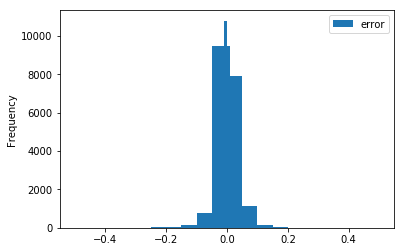

In [41]:
results_df, results_array = pred_MCdropout(model_MC, X_test, y_test, 100)
results_df.head()